## Index

1. [Importing Libraries](#L1)
<br/><br/>
2. [Utility Functions](#L2)
<br/><br/>
3. [Set working directory](#L3)
<br/><br/>
5. [Read the entire image dataset](#L4)
<br/><br/>
6. [Subset the image dataset](#L5)
    - 5.1. [Train - EachClass=10, Test - 100, RGB](#L5.1)
    - 5.2. [Train - EachClass=10, Test - 100, GREY_SCALE](#L5.2)
    - 5.3. [Train - EachClass=10, Test - 100, RGB, SHRINKED](#L5.3)
    - 5.4. [Train - EachClass=10, Test - 100, GREY_SCALE, SHRINKED](#L5.4)
<br/><br/>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">1. Importing Libraries</span>

Library for ignoring warnings while importing Libraries, Deprecation Warnings etc..

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from IPython import display
import time
import shutil
import logging
import datetime

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
#%matplotlib inline

In [5]:
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [6]:
from PIL import Image

In [7]:
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D,ZeroPadding2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values

Using TensorFlow backend.


In [8]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [10]:
logging.basicConfig(filename='CNNCapstoneLog.log',level=logging.DEBUG)
ts = datetime.datetime.now()
logging.info("******************************************************************")
logging.info("Execution started at - "+ts.strftime("%Y-%m-%d %H:%M:%S"))

[Click here to go to top](#TOP).

<span style="color:#337AFF;font-size:18px;font-weight:bold;">2. Utility Functions </span>

<a id='L2.1'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.1. Func - Set Working Directory Path</span>

In [11]:
def fun_SetWorkingDirectoryPath(directoryPath):
    os.chdir(directoryPath)

<a id='L2.2'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.2. Func - Delete Working Directory</span>

In [12]:
def fun_DeleteWorkingDirectory(working_dir_path):
    if os.path.exists(working_dir_path):
        shutil.rmtree(working_dir_path)
        logging.info("Deleted Working Directory")
        print("Deleted Working Directory Successfully !")
    else:
        logging.error("Directory Doesn't Exist")
        print("Directory Doesn't Exist !")
    print("")

<a id='L2.3'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.3. Func - Create Working Directory</span>

In [13]:
def fun_CreateWorkingDirectories(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(directory + "  -  Created !")
        print(directory + "  -  Created !")
    print("")

<a id='L2.4'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.4. Func - Recursive List Files</span>

In [14]:
def fun_GetFilesList(directoryPath):
    files_list = []
    for root, directories, filenames in os.walk(directoryPath):
        for filename in filenames:
            iterImage = filename.upper()
            if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
                files_list.append(os.path.join(root,filename))
    
    return(files_list)

<a id='L2.5'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.5. Func - Convert File_Images_List to Arrays</span>

In [15]:
def fun_ConvertImagesToArray(readFile, imageFilesList):
    imageFileArray = []
    filesReadCount = 0
    #for tempImages in imageFilesList:
    logging.debug("Reading {0} images :".format(readFile))
    print("Reading {0} images :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            tempArray = np.array(Image.open(tempImages))
            if (len(tempArray.shape))==2:
                tempShape = tempArray.shape
                tempArray = tempArray.reshape(tempShape[0], tempShape[1], 1)
            imageFileArray.append(tempArray)
            filesReadCount = filesReadCount + 1
    print("")
        
    return(np.asarray(imageFileArray))

<a id='L2.6'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.6. Func - Generate Labels from File Names</span>

In [16]:
def fun_GetLabelsFromFileNames(entire_images_list):
    Y_Master = []
    for image_name in entire_images_list:
        try:
            temp = image_name.split("/")
            Y_Master.append(int(temp[len(temp)-2][1]))
        except:
            continue
    return(Y_Master)

<a id='L2.7'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.7. Func - Convert Images to Grey Scale and Save Them</span>

In [17]:
def fun_ConvertImages(source_dir_path,working_dir_path,readFile, imageFilesList, resizeHeight=None, resizeWidth=None, isGrayScaledConversion=False):
    imageFileArray = []
    filesReadCount = 0
    print("Converting {0} to the desired format :".format(readFile))
    for tempImages in log_progress(imageFilesList, every=1):
        iterImage = tempImages.upper()
        if(iterImage.endswith(".JPG") or iterImage.endswith(".JPEG") or iterImage.endswith(".PNG")):
            image=Image.open(tempImages)
            
            if (resizeHeight is not None and resizeWidth is not None):
                image = image.resize((resizeHeight, resizeWidth))

            if (isGrayScaledConversion):
                image=image.convert('L')

            #temp = tempImages.replace("Complete Dataset", "Working Dir")
            temp = tempImages.replace(source_dir_path, working_dir_path)
            
            image.save(temp)
            imageFileArray.append(temp)
            filesReadCount = filesReadCount + 1
            
    return (readFile, imageFileArray)

<a id='L2.8'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.8. Func - Frame X_Train and Y_Train</span>

In [18]:
def fun_oneHotEncode(labels, num_classes):
    values = np.array(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    values=values.reshape(len(values), 1)
    onehot_encoded = to_categorical(values)
    return onehot_encoded

In [19]:
def fun_Get_X_Y_Date(source_dir_path, working_dir_path, is_train, total_number_of_records, test_percentage, is_gray_scaled, resizeHeight, resizeWidth, num_classes):
    train_test_path = "";
    
    if(is_train):
        train_test_path = "/imgs/train/"
    else:
        train_test_path = "/imgs/test/"
    
    fun_Delete_And_Create_Working_Dir(working_dir_path, is_train, train_test_path)
    
    entire_images_list = []
    print(source_dir_path + train_test_path)
    entire_images_list = fun_GetFilesList(source_dir_path + train_test_path)
    print("(entire_images_list) {0}:".format(len(entire_images_list)))
    
    entire_labels_list = []
    if(is_train):
        entire_labels_list = fun_GetLabelsFromFileNames(entire_images_list)
        print("(entire_labels_list) {0} :".format(len(entire_labels_list)))
    else:
        entire_labels_list = np.full(np.array(entire_images_list).shape, 100)
        
    
    filePath_Labels_List_df = pd.DataFrame(
                                            {
                                                'Files_Path': entire_images_list,
                                                'Labels'    : entire_labels_list
                                            }
    )

    train_test_filePath_Labels_List_df = filePath_Labels_List_df.sample(n=total_number_of_records, random_state=10)
    
    if(is_train):
        for i in range(num_classes):
            print("(Label, Number of Rows) : ({0}, {1})".format(i, len(train_test_filePath_Labels_List_df[train_test_filePath_Labels_List_df["Labels"]==i])))
            print("")
            
    train_test_filePath_Labels_List_df.sample(frac=1, random_state=10)
    
    X_train, X_test, Y_train, Y_test = (train_test_split(
                                                train_test_filePath_Labels_List_df["Files_Path"], 
                                                train_test_filePath_Labels_List_df["Labels"], 
                                                test_size = test_percentage,
                                                random_state = 10
                                            )
                                   )
    print("(X_train, Y_train) : ({0}, {1})".format(len(X_train), len(Y_train)))
    print("(X_test, Y_test)   : ({0}, {1})".format(len(X_test), len(Y_test)))
    print("")

    (readFile, imageFileArray) = fun_ConvertImages(
                            source_dir_path + train_test_path,
                            working_dir_path + train_test_path,
                            readFile="X_train",
                            imageFilesList=X_train, 
                            resizeHeight=resizeHeight, 
                            resizeWidth=resizeWidth, 
                            isGrayScaledConversion=is_gray_scaled
                    )
    X_train = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
    X_train = X_train.astype('float32') 
    #Y_train = Y_train.astype('float32') 
    
    # Normalise data to [0, 1] range
    X_train /= np.max(X_train)
    #Y_train /= np.max(Y_train)
    
    #Y_train = np_utils.to_categorical(Y_train, num_classes) # One-hot encode the labels
    
    # One-hot encode the train labels
    Y_train_oneHot = fun_oneHotEncode(Y_train, num_classes)
    
    print("(X_train.shape, Y_train.shape) : ({0}, {1})".format(X_train.shape, Y_train.shape))
    
    if(len(X_test) is not 0):
        (readFile, imageFileArray) = fun_ConvertImages(
                                source_dir_path + train_test_path,
                                working_dir_path + train_test_path,
                                readFile="X_test",
                                imageFilesList=X_test, 
                                resizeHeight=resizeHeight, 
                                resizeWidth=resizeWidth, 
                                isGrayScaledConversion=is_gray_scaled
                        )
        X_test  = fun_ConvertImagesToArray(
                       readFile,
                       imageFileArray
                  )
        
        X_test = X_test.astype('float32') 
        #Y_test = Y_test.astype('float32')
    
        # Normalise data to [0, 1] range
        X_test /= np.max(X_test)
        #Y_test /= np.max(Y_test)
        
        #Y_test = np_utils.to_categorical(Y_test, num_classes) # One-hot encode the labels
        
        # One-hot encode the test labels
        Y_test_oneHot = fun_oneHotEncode(Y_test, num_classes)
        
        print("(X_test.shape, Y_test.shape) : ({0}, {1})".format(X_test.shape, Y_test.shape))    
    
        
    print("")        
    
    num_train, height, width, depth = X_train.shape
    inp = Input(shape=(height, width, depth)) # N.B. depth goes first in Keras!
                                       
    return (X_train, X_test, Y_train, Y_train_oneHot, Y_test, Y_test_oneHot, num_train, height, width, depth, inp, train_test_filePath_Labels_List_df)


<a id='L2.9'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.9. Func - Delete and Create Working Directory</span>

In [20]:
def fun_Delete_And_Create_Working_Dir(working_dir_path, is_train, train_test_path):
    dir_path = working_dir_path + train_test_path
    print("direcory path", dir_path)
    
    fun_DeleteWorkingDirectory(dir_path)
        
    if(is_train):
        for i in range(0,10):
            fun_CreateWorkingDirectories(dir_path + "c" + str(i))
    else:
        fun_CreateWorkingDirectories(dir_path)

<a id='L2.10'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.10. Func - Progress Bar</span>

In [21]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

<a id='L2.11'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.11. Func - Frame Convolutional Layers</span>

In [22]:
def fun_FrameConvolutionalLayers(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob):
    conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)
    max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)
    dropout_layer = Dropout(drop_prob)(max_pol_layer)
    logging.debug("conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)")
    logging.debug("max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)")
    logging.debug("dropout_layer = Dropout(drop_prob)(max_pol_layer)")
    logging.debug(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob)
    print("conv_layer    = Convolution2D(filters = no_of_filters, kernel_size = (c_filter_dim, c_filter_dim), strides = (c_stride_dim, c_stride_dim), activation=activation)(prev_c_mp_dp_layer)")
    print("max_pol_layer = MaxPooling2D(pool_size=(mp_dim, mp_dim), strides=(mp_stride, mp_stride))(conv_layer)")
    print("dropout_layer = Dropout(drop_prob)(max_pol_layer)")
    print(prev_c_mp_dp_layer, no_of_filters, c_filter_dim, c_stride_dim, activation, mp_dim, mp_stride, drop_prob)
    
    return(dropout_layer)

<a id='L2.12'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.12. Func - Frame Dense Layers</span>

In [23]:
def fun_FrameDenseLayers(flatten_layer, layer_size, activation, drop_prob):
    hidden_layer  = Dense(layer_size, activation=activation)(flatten_layer)
    dropout_layer = Dropout(drop_prob)(hidden_layer)
    
    return(dropout_layer)

<a id='L2.13'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.13. Func - Read Convolutional Layer Definitions</span>

In [24]:
def fun_ReadConvolutionLayerDefinitions(excelFileName, sheetName):
    convolution_definitions = pd.read_excel(excelFileName, sheet_name=sheetName,header=1)
    convolution_definitions
    logging.debug("Total Groups in Convolutional Layer: " + str(len(convolution_definitions["Group"].value_counts())))
    print("Total Groups in Convolutional Layer: " + str(len(convolution_definitions["Group"].value_counts())))
    print("")
    
    return(convolution_definitions)

<a id='L2.14'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.14. Func - Read Dense Layer Definitions</span>

In [25]:
def fun_ReadDenseLayerDefinitions(excelFileName, sheetName):
    dense_definitions = pd.read_excel(excelFileName, sheet_name=sheetName)
    logging.debug("Total Groups in Dense Layer: " + str(len(dense_definitions["Group"].value_counts())))
    print("Total Groups in Dense Layer: " + str(len(dense_definitions["Group"].value_counts())))
    print("")
    
    return(dense_definitions)

<a id='L2.15'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.15. Func - Compile and Fit Model</span>

In [26]:
def fun_CompileAndFitModel(cnn_output_df, loss, optimizer, metrics, X_train, Y_train, X_test, Y_test, batch_size, num_epochs, validation_split, num_classes):
    
    cnn_output_df["loss"] = ""
    cnn_output_df["accuracy"] = ""
    for index_cnn, row_cnn in cnn_output_df.iterrows():
        model = row_cnn["conv_dense_layer"]
        
        logging.debug("Processing Group-{0}".format(row_cnn["group_id"]))
        print("Processing Group-{0}".format(row_cnn["group_id"]))
        model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
        earlyStop=EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, \
                          verbose=1, mode='auto')
        callback = [earlyStop]
        model.fit(
                    X_train, 
                    Y_train,
                    batch_size=batch_size,
                    nb_epoch=num_epochs,
                    verbose=1, 
                    validation_split=validation_split,
                    callbacks=callback
        )
        row_cnn["conv_dense_layer"] = model
        scores=model.evaluate(X_test, Y_test, verbose=1)
        row_cnn["loss"] = scores[0]
        row_cnn["accuracy"] = scores[1] * 100
        logging.debug("Accuracy is: {0}".format(row_cnn["accuracy"]*100))
        print("Accuracy is: {0}".format(row_cnn["accuracy"]))
        print("")
        print("")
    
    return(cnn_output_df)

<a id='L2.16'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.16. Func - Evaluate Model</span>

In [27]:
def fun_EvaluateModel(model):
    return(model.evaluate(X_test, Y_test, verbose=1))

<a id='L2.17'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.17. Func - Print Model Summary</span>

In [28]:
def fun_PrintModelSummary(model):
    return(model.summary())

<a id='L2.18'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.18. Func - Generate Convolutional Layers</span>

In [29]:
def fun_GenerateConvolutions(convolutional_layers):
    temp_group_value = None
    final_layer      = None
    conv_layer_list  = []
    conv_group_list  = []
    model = None

    for index, row in convolutional_layers.iterrows():
        if(row["Is_Active"]=="Y"):
        
            if(temp_group_value != row["Group"]):
                print("")
                logging.debug("Processing Convolutional Group-{0}".format(row["Group"]))
                print("Processing Convolutional Group-{0}".format(row["Group"]))
                temp_group_value = row["Group"]
                paddingVal="Same"
                mppaddingVal="Same"
                if row["c_padding_no"]==0:
                    paddingVal="Valid"

                if row["mp_padding_no"]==0:
                    mppaddingVal="Valid"

                if(model is not None):
                    conv_group_list.append(int(row["Group"])-1)
                    model.add(Flatten())
                    conv_layer_list.append(model)

                model = Sequential()
                model.add(Conv2D(row["c_filter_no"], kernel_size=(row["c_filter_dim"], row["c_filter_dim"]),\
                                 strides=(row["c_stride_dim"], row["c_stride_dim"]), input_shape=(width, height, depth),\
                                 padding=paddingVal ,activation=row["activation"]))
            else:
                model.add(Conv2D(row["c_filter_no"], kernel_size=(row["c_filter_dim"], row["c_filter_dim"]),\
                                 strides=(row["c_stride_dim"], row["c_stride_dim"]), \
                                 padding=paddingVal, activation=row["activation"]))
            model.add(MaxPooling2D(pool_size=(row["mp_dim"], row["mp_dim"]), strides=(row["mp_stride"], row["mp_stride"]),\
                                  padding=mppaddingVal ))
            model.add(BatchNormalization())
            model.add(Dropout(row["drop_prob"]))
        
    conv_group_list.append(row["Group"])
    model.add(Flatten())
    conv_layer_list.append(model)

    conv_group_df = pd.DataFrame(
                                    {
                                        'group_id'  : conv_group_list,
                                        'conv_layer' : conv_layer_list
                                    }
    )
    print("")
    
    return(conv_group_df)
    

<a id='L2.19'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.19. Func - Generate Dense Layers</span>

In [30]:
def fun_GenerateDenses(convolutional_layers_df, dense_layers, num_classes):
    dense_layer_list = []
    dense_group_list  = []

    for index_conv, row_conv in convolutional_layers_df.iterrows():
        model = row_conv["conv_layer"]

        final_layer = None
        temp_dense_row_id = None
        
        for index_dense, row_dense in dense_layers.iterrows():
            if(row_dense["Is_Active"]):
                if(temp_dense_row_id != int(row_dense["Group"])):
                    if(temp_dense_row_id is not None):
                        model.add(Dense(num_classes, activation=row_dense["activation"]))
                        dense_group_list.append(str(row_conv["group_id"]) + "-" + str(row_dense["Group"]-1))
                        dense_layer_list.append(model)
                        print("")

                    temp_dense_row_id = int(row_dense["Group"])   
                    logging.debug("Processing Conv Group-{0}, Dense Group-{1}".format(row_conv["group_id"], row_dense["Group"]))
                    print("Processing Conv Group-{0}, Dense Group-{1}".format(row_conv["group_id"], row_dense["Group"]))

                model.add(Dense(row_dense["layer_size"], activation=row_dense["activation"]))
        
        dense_group_list.append(str(row_conv["group_id"]) + "-" + str(row_dense["Group"]))
        dense_layer_list.append(model)
        print("")
        
            
    dense_group_df = pd.DataFrame(
                                    {
                                        'group_id'         : dense_group_list,
                                        'conv_dense_layer' : dense_layer_list
                                    }
    )
    print("")
    
    return(dense_group_df)
    

<a id='L2.20'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.20. Func - Generate CNN Output Dataframe</span>

In [31]:
def fun_GenerateCNNOutputDataFrame(convolutional_layers, dense_layers, num_classes):
    convolutional_layers_df = fun_GenerateConvolutions(convolutional_layers)
    dense_layers_df = fun_GenerateDenses(convolutional_layers_df, dense_layers, num_classes)
    
    return(dense_layers_df)

<a id='L2.21'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.21. Func - Save Model</span>

In [32]:
def save_model(working_dir_path, model, index, cross=''):
    print(model)
    json_string = model.to_json()
    if not os.path.isdir(working_dir_path + '/cache'):
        os.mkdir(working_dir_path + '/cache')
    json_name = 'architecture' + "_" + str(index) + "_" + cross + '.json'
    weight_name = 'model_weights' + "_" + str(index) + "_" + cross + '.h5'
    open(os.path.join(working_dir_path + '/cache', json_name), 'w').write(json_string)
    print(working_dir_path + '/cache')
    model.save_weights(os.path.join(working_dir_path + '/cache', weight_name), overwrite=True)

<a id='L2.22'></a>
<span style="color:#337AFF;font-size:18px;font-weight:bold;">2.22. Func - Read Model</span>

In [33]:
def read_model(working_dir_path, index, cross=''):
    json_name = 'architecture' + "_" + str(index) + "_" + cross + '.json'
    weight_name = 'model_weights' + "_" + str(index) + "_" + cross + '.h5'
    model = model_from_json(open(os.path.join(working_dir_path + '/cache', json_name)).read())
    model.load_weights(os.path.join(working_dir_path + '/cache', weight_name),by_name=True)
    return model

<span style="color:#337AFF;font-size:18px;font-weight:bold;">3. Define Working Directory</span>

In [34]:
#fun_SetWorkingDirectoryPath("/Users/LeninSV/Desktop/LeninKumar SV/temp/")
#fun_SetWorkingDirectoryPath("/Users/LeninSV/Desktop/LeninKumar SV/ddtemp/Complete Dataset/imgs/train/")

In [35]:
source_dir_path = "/Users/LeninSV/Desktop/LeninKumar SV/temp/Complete Dataset"

In [36]:
working_dir_path = "/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir"

[Click here to go to top](#TOP).

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4. Converting Images to GreyScale Resized</span>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">Resizing from 480 / 640 ---> 480 / 480  (Width / Height)</span>

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4.1. Frame Data</span>

In [38]:
source_dir_path

'/Users/LeninSV/Desktop/LeninKumar SV/temp/Complete Dataset'

In [39]:
source_dir_path + "/imgs/train/"

'/Users/LeninSV/Desktop/LeninKumar SV/temp/Complete Dataset/imgs/train/'

In [40]:
(X_train, 
 X_test, 
 Y_train,
 Y_train_oneHot,
 Y_test, 
 Y_test_oneHot,
 num_train, 
 height, 
 width, 
 depth, 
 inp,
train_test_filePath_Labels_List_df_1) = fun_Get_X_Y_Date(
                        source_dir_path, 
                        working_dir_path,
                        is_train=True,
                        total_number_of_records=10000,
                        test_percentage=0.3,
                        is_gray_scaled=True, 
                        resizeHeight=224, 
                        resizeWidth=224, 
                        num_classes=10
        )

direcory path /Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/
Deleted Working Directory Successfully !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c0  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c1  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c2  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c3  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c4  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c5  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c6  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c7  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c8  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/imgs/train/c9  -  Created !

/Users/LeninSV/Desktop/LeninKumar SV/temp/Comple

VBox(children=(HTML(value=''), IntProgress(value=0, max=70)))

Reading X_train images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=70)))


(X_train.shape, Y_train.shape) : ((70, 224, 224, 1), (70,))
Converting X_test to the desired format :


VBox(children=(HTML(value=''), IntProgress(value=0, max=30)))

Reading X_test images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=30)))


(X_test.shape, Y_test.shape) : ((30, 224, 224, 1), (30,))



In [41]:
#height = 224
#width = 224
#depth = 1

In [42]:
np.save(working_dir_path + "/cache/X_train_4500", X_train)

In [43]:
np.save(working_dir_path + "/cache/Y_train_4500", Y_train)

In [44]:
np.save(working_dir_path + "/cache/X_test_4500", X_test)

In [45]:
np.save(working_dir_path + "/cache/Y_test_4500", Y_test)

In [46]:
np.save(working_dir_path + "/cache/Y_train_oneHot_4500", Y_train_oneHot)

In [47]:
np.save(working_dir_path + "/cache/Y_test_oneHot_4500", Y_test_oneHot)

### Load Numpy Arrays

In [37]:
X_train = np.load(working_dir_path + "/cache/X_train_4500.npy")

In [38]:
Y_train = np.load(working_dir_path + "/cache/Y_train_4500.npy")

In [39]:
X_test = np.load(working_dir_path + "/cache/X_test_4500.npy")

In [40]:
Y_test = np.load(working_dir_path + "/cache/Y_test_4500.npy")

In [41]:
Y_train_oneHot = np.load(working_dir_path + "/cache/Y_train_oneHot_4500.npy")

In [42]:
Y_test_oneHot = np.load(working_dir_path + "/cache/Y_test_oneHot_4500.npy")

In [43]:
#a = np.squeeze(X_train[0])

In [53]:
#plt.imshow(a)

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4.2. Read Convolution and Dense Layer Definitions</span>

In [54]:
excelFileName = source_dir_path + "/CNNGridSearchSource.xlsx"

In [55]:
convolutionDefinitionsSheetName = "Convolution Layer"
denseDefinitionsSheetName       = "Dense Layer"

In [56]:
convolutional_layers = fun_ReadConvolutionLayerDefinitions(excelFileName, convolutionDefinitionsSheetName)
convolutional_layers

Total Groups in Convolutional Layer: 1



Is_Active  Group  #  layer_size  c_filter_no  c_filter_dim  c_padding_no  \
0          N      1  1         224           96            11             0   
1          N      1  2          27          256            11             0   
2          N      1  3           9          384             3             0   
3          N      1  4           7          384             3             0   
4          N      1  4           5          256             3             0   
5          N      1  1         224           96             3             0   
6          N      1  2          56          188             3             0   
7          N      1  3          14          256             3             0   
8          N      1  4          11          384             3             0   
9          N      1  4           8          768             3             0   
10         Y      1  1         224           96             3             0   
11         Y      1  2          56          188             3             0   
12         Y      1  3          14          256             3             0   
13         Y      1  4          11          384             3             0   
14         Y      1  4           8          768             3             0   

    c_stride_dim activation  c_output  c_output_channels  mp_dim  \
0              4       relu        54                 96       2   
1              1       relu        17                256       2   
2              1       relu         7                384       1   
3              1       relu         5                384       1   
4              1       relu         3                256       2   
5              2       relu       112                 96       2   
6              2       relu        28                188       2   
7              1       relu        12                256       2   
8              1       relu         9                384       2   
9              1       relu         6                768       2   
10             2       relu       112                 96       2   
11             2       relu        28                188       2   
12             1       relu        12                256       2   
13             1       relu         9                384       2   
14             1       relu         6                768       2   

    mp_padding_no  mp_stride  mp_output  mp_output_channels  drop_prob  
0               0          2         27                  96        0.1  
1               0          2          9                 256        0.1  
2               0          1          7                 384        0.1  
3               0          1          5                 384        0.1  
4               0          2          2                 256        0.1  
5               0          2         56                  96        0.1  
6               0          2         14                 188        0.1  
7               0          1         11                 256        0.1  
8               0          1          8                 384        0.1  
9               0          1          5                 768        0.1  
10              0          2         56                  96        0.1  
11              0          2         14                 188        0.1  
12              0          1         11                 256        0.1  
13              0          1          8                 384        0.1  
14              0          1          5                 768        0.1

In [57]:
dense_layers = fun_ReadDenseLayerDefinitions(excelFileName, denseDefinitionsSheetName)
dense_layers

Total Groups in Dense Layer: 1



Is_Active  Group  #  layer_size activation  drop_prob
0         Y      1  1        4500       relu        0.1
1         Y      1  2        2250       relu        0.1
2         Y      1  3        1250       relu        0.1
3         Y      1  4         600       relu        0.1
4         Y      1  5         300       relu        0.1
5         Y      1  6         150       relu        0.1
6         Y      1  7          75       relu        0.1
7         Y      1  8          30       relu        0.1
8         Y      1  9          10    softmax        0.1

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4.3. Generate CNN Output</span>

In [58]:
cnn_output_df = fun_GenerateCNNOutputDataFrame(convolutional_layers, dense_layers, 10)


Processing Convolutional Group-1

Processing Conv Group-1, Dense Group-1




In [59]:
cnn_output_df

conv_dense_layer group_id
0  <keras.engine.sequential.Sequential object at ...      1-1

<span style="color:#337AFF;font-size:18px;font-weight:bold;">4.5. Generate Models</span>

In [60]:
cnn_output_df.loc[0,"conv_dense_layer"].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 111, 111, 96)      960       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 188)       162620    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 188)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 188)       752       
__________

In [61]:
model_without_compiling = cnn_output_df.loc[0,"conv_dense_layer"]

In [63]:
loss="categorical_crossentropy"
optimizer="adam"
metrics="accuracy"
batch_size = 100
num_epochs = 30
validation_split=0.2
num_classes=10

In [64]:
model_df = fun_CompileAndFitModel(
                                cnn_output_df, 
                                loss, 
                                optimizer, 
                                metrics, 
                                X_train, 
                                Y_train_oneHot,
                                X_test, 
                                Y_test_oneHot,
                                batch_size, 
                                num_epochs, 
                                validation_split,
                                num_classes
            )

Processing Group-1-1
Train on 56 samples, validate on 14 samples
Epoch 1/2
56/56 [==============================] - 28s 503ms/step - loss: 3.3223 - acc: 0.1250 - val_loss: 8.1121 - val_acc: 0.0714
Epoch 2/2
30/30 [==============================] - 1s 31ms/step
Accuracy is: 6.666667014360428




In [66]:
save_model(working_dir_path, model_df.loc[0,"conv_dense_layer"], 0, cross='customeModel')

/Users/LeninSV/Desktop/LeninKumar SV/temp/Working Dir/cache


In [44]:
model = read_model(working_dir_path, 0, cross='customeModel')

In [ ]:
Y_pred = model.predict_classes(X_test)

In [ ]:
accuracy_score(Y_pred, Y_test)

In [ ]:
a = confusion_matrix(Y_test, Y_pred)

In [ ]:
#a[3][0] = 100

In [ ]:
a

In [51]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
df_cm = pd.DataFrame(a, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])

In [53]:
df_cm

0    1    2    3    4    5    6    7    8    9
0  679    0    0    1    0    5    0    0    7    4
1    1  611    1    0    0    1    0    0    4    0
2    0    0  608    0    0    0    2    0    9    0
3    1    0    0  634    0    0    0    0    1    0
4    2    0    0    1  585    1    0    0    3    0
5    0    0    0    0    0  622    0    0    0    2
6    0    5    0    0    0    1  593    0   13    0
7    0    0    0    0    0    0    0  512   21    2
8    2    0    1    0    2    8    2    2  469    6
9    6    0    0    0    0    8    0    1    6  555

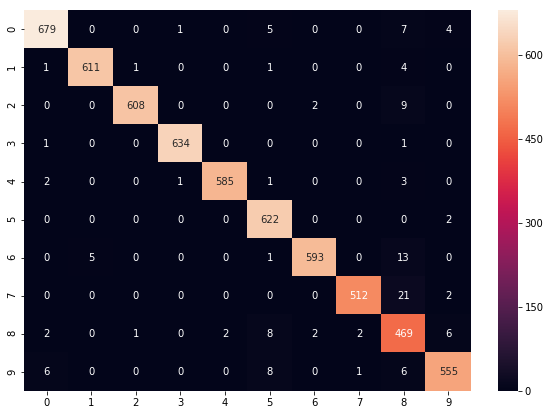

In [54]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt=".7g")

In [124]:
import scikitplot as skplt

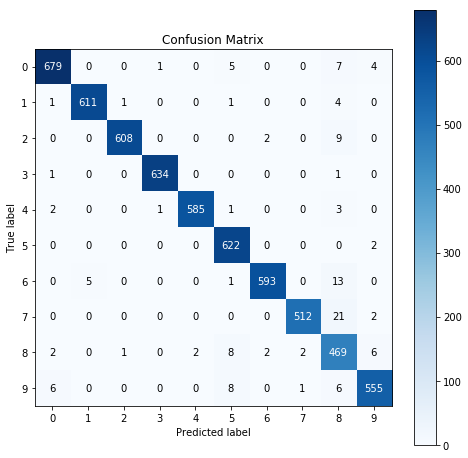

In [125]:
skplt.metrics.plot_confusion_matrix(Y_test, Y_pred, figsize=(8,8))

In [126]:
import matplotlib.pyplot as plt

In [127]:
import scikitplot as skplt

In [128]:
Y_prob = model.predict_proba(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


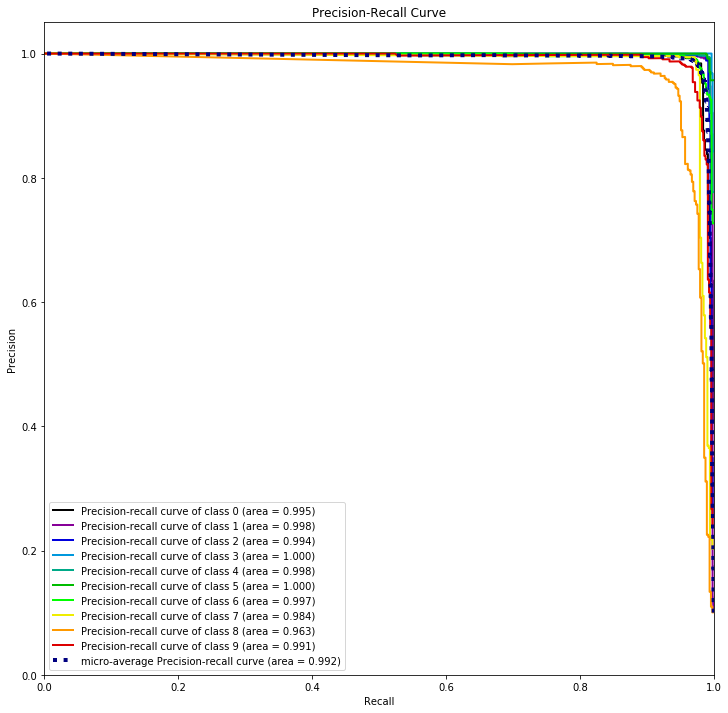

In [129]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_prob, figsize=(12,12))

In [60]:
# Predict
y_pred_p = model.predict_classes(X_test, batch_size=100, verbose=1)

6000/6000 [==============================] - 243s 40ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [61]:
test_acc = round(accuracy_score(Y_test, y_pred_p.round())*100)
print("Test accuracy:", test_acc)

Test accuracy: 98.0


In [83]:
resultList = []
classType = []
for i in range(len(X_test)):
    preds = y_pred_p[i]
    print("Predictions", i, preds)
    print("Labels", i, Y_test[i])
    if(preds == Y_test[i]):
        resultList.append("right")
        classType.append(Y_test[i])
    else:
        resultList.append("wrong")
        classType.append(Y_test[i])

Predictions 0 0
Labels 0 0
Predictions 1 2
Labels 1 2
Predictions 2 4
Labels 2 4
Predictions 3 6
Labels 3 6
Predictions 4 6
Labels 4 6
Predictions 5 5
Labels 5 5
Predictions 6 8
Labels 6 8
Predictions 7 6
Labels 7 6
Predictions 8 9
Labels 8 9
Predictions 9 7
Labels 9 7
Predictions 10 5
Labels 10 5
Predictions 11 6
Labels 11 6
Predictions 12 1
Labels 12 1
Predictions 13 5
Labels 13 5
Predictions 14 1
Labels 14 1
Predictions 15 9
Labels 15 9
Predictions 16 7
Labels 16 7
Predictions 17 4
Labels 17 4
Predictions 18 6
Labels 18 6
Predictions 19 4
Labels 19 4
Predictions 20 3
Labels 20 3
Predictions 21 8
Labels 21 8
Predictions 22 1
Labels 22 1
Predictions 23 1
Labels 23 1
Predictions 24 5
Labels 24 5
Predictions 25 6
Labels 25 6
Predictions 26 8
Labels 26 8
Predictions 27 3
Labels 27 3
Predictions 28 9
Labels 28 9
Predictions 29 4
Labels 29 4
Predictions 30 3
Labels 30 3
Predictions 31 4
Labels 31 4
Predictions 32 0
Labels 32 0
Predictions 33 9
Labels 33 9
Predictions 34 1
Labels 34 1
Predi

Labels 321 2
Predictions 322 1
Labels 322 1
Predictions 323 9
Labels 323 9
Predictions 324 2
Labels 324 2
Predictions 325 2
Labels 325 2
Predictions 326 2
Labels 326 2
Predictions 327 8
Labels 327 8
Predictions 328 5
Labels 328 5
Predictions 329 1
Labels 329 1
Predictions 330 1
Labels 330 1
Predictions 331 2
Labels 331 2
Predictions 332 8
Labels 332 8
Predictions 333 5
Labels 333 5
Predictions 334 1
Labels 334 1
Predictions 335 5
Labels 335 5
Predictions 336 0
Labels 336 0
Predictions 337 9
Labels 337 9
Predictions 338 9
Labels 338 9
Predictions 339 0
Labels 339 0
Predictions 340 1
Labels 340 1
Predictions 341 3
Labels 341 3
Predictions 342 2
Labels 342 2
Predictions 343 1
Labels 343 1
Predictions 344 9
Labels 344 9
Predictions 345 3
Labels 345 3
Predictions 346 7
Labels 346 7
Predictions 347 6
Labels 347 6
Predictions 348 1
Labels 348 1
Predictions 349 2
Labels 349 2
Predictions 350 0
Labels 350 0
Predictions 351 0
Labels 351 0
Predictions 352 5
Labels 352 5
Predictions 353 6
Labels 3

Labels 654 9
Predictions 655 3
Labels 655 3
Predictions 656 8
Labels 656 8
Predictions 657 4
Labels 657 4
Predictions 658 0
Labels 658 0
Predictions 659 7
Labels 659 7
Predictions 660 1
Labels 660 1
Predictions 661 4
Labels 661 4
Predictions 662 9
Labels 662 9
Predictions 663 8
Labels 663 6
Predictions 664 8
Labels 664 8
Predictions 665 1
Labels 665 1
Predictions 666 4
Labels 666 4
Predictions 667 5
Labels 667 5
Predictions 668 0
Labels 668 0
Predictions 669 5
Labels 669 5
Predictions 670 7
Labels 670 7
Predictions 671 8
Labels 671 7
Predictions 672 0
Labels 672 0
Predictions 673 0
Labels 673 0
Predictions 674 1
Labels 674 1
Predictions 675 9
Labels 675 9
Predictions 676 4
Labels 676 4
Predictions 677 8
Labels 677 8
Predictions 678 2
Labels 678 2
Predictions 679 9
Labels 679 9
Predictions 680 3
Labels 680 3
Predictions 681 3
Labels 681 3
Predictions 682 8
Labels 682 8
Predictions 683 9
Labels 683 9
Predictions 684 0
Labels 684 0
Predictions 685 7
Labels 685 7
Predictions 686 6
Labels 6

Labels 987 6
Predictions 988 2
Labels 988 2
Predictions 989 0
Labels 989 0
Predictions 990 8
Labels 990 8
Predictions 991 8
Labels 991 8
Predictions 992 3
Labels 992 3
Predictions 993 1
Labels 993 1
Predictions 994 7
Labels 994 7
Predictions 995 3
Labels 995 3
Predictions 996 3
Labels 996 3
Predictions 997 8
Labels 997 8
Predictions 998 7
Labels 998 7
Predictions 999 9
Labels 999 9
Predictions 1000 8
Labels 1000 8
Predictions 1001 6
Labels 1001 6
Predictions 1002 9
Labels 1002 0
Predictions 1003 5
Labels 1003 5
Predictions 1004 0
Labels 1004 0
Predictions 1005 2
Labels 1005 2
Predictions 1006 6
Labels 1006 6
Predictions 1007 0
Labels 1007 0
Predictions 1008 3
Labels 1008 3
Predictions 1009 3
Labels 1009 3
Predictions 1010 4
Labels 1010 4
Predictions 1011 2
Labels 1011 2
Predictions 1012 9
Labels 1012 9
Predictions 1013 5
Labels 1013 5
Predictions 1014 1
Labels 1014 1
Predictions 1015 8
Labels 1015 7
Predictions 1016 5
Labels 1016 5
Predictions 1017 4
Labels 1017 4
Predictions 1018 1
La

Predictions 1237 9
Labels 1237 9
Predictions 1238 1
Labels 1238 1
Predictions 1239 4
Labels 1239 4
Predictions 1240 0
Labels 1240 0
Predictions 1241 0
Labels 1241 0
Predictions 1242 0
Labels 1242 0
Predictions 1243 3
Labels 1243 3
Predictions 1244 2
Labels 1244 2
Predictions 1245 4
Labels 1245 4
Predictions 1246 5
Labels 1246 5
Predictions 1247 7
Labels 1247 7
Predictions 1248 1
Labels 1248 1
Predictions 1249 4
Labels 1249 4
Predictions 1250 1
Labels 1250 1
Predictions 1251 4
Labels 1251 4
Predictions 1252 6
Labels 1252 6
Predictions 1253 0
Labels 1253 0
Predictions 1254 0
Labels 1254 0
Predictions 1255 7
Labels 1255 7
Predictions 1256 9
Labels 1256 9
Predictions 1257 5
Labels 1257 5
Predictions 1258 6
Labels 1258 6
Predictions 1259 3
Labels 1259 3
Predictions 1260 9
Labels 1260 9
Predictions 1261 3
Labels 1261 3
Predictions 1262 6
Labels 1262 6
Predictions 1263 5
Labels 1263 5
Predictions 1264 7
Labels 1264 7
Predictions 1265 6
Labels 1265 6
Predictions 1266 6
Labels 1266 6
Prediction

Predictions 1553 4
Labels 1553 4
Predictions 1554 2
Labels 1554 2
Predictions 1555 6
Labels 1555 6
Predictions 1556 1
Labels 1556 1
Predictions 1557 8
Labels 1557 8
Predictions 1558 9
Labels 1558 9
Predictions 1559 1
Labels 1559 1
Predictions 1560 8
Labels 1560 8
Predictions 1561 3
Labels 1561 3
Predictions 1562 8
Labels 1562 8
Predictions 1563 1
Labels 1563 1
Predictions 1564 0
Labels 1564 0
Predictions 1565 0
Labels 1565 0
Predictions 1566 7
Labels 1566 7
Predictions 1567 2
Labels 1567 2
Predictions 1568 0
Labels 1568 0
Predictions 1569 6
Labels 1569 6
Predictions 1570 9
Labels 1570 9
Predictions 1571 0
Labels 1571 0
Predictions 1572 2
Labels 1572 2
Predictions 1573 4
Labels 1573 4
Predictions 1574 2
Labels 1574 2
Predictions 1575 9
Labels 1575 9
Predictions 1576 7
Labels 1576 7
Predictions 1577 8
Labels 1577 8
Predictions 1578 7
Labels 1578 7
Predictions 1579 8
Labels 1579 8
Predictions 1580 4
Labels 1580 4
Predictions 1581 3
Labels 1581 3
Predictions 1582 2
Labels 1582 2
Prediction

Predictions 1820 0
Labels 1820 0
Predictions 1821 5
Labels 1821 5
Predictions 1822 9
Labels 1822 9
Predictions 1823 7
Labels 1823 8
Predictions 1824 6
Labels 1824 6
Predictions 1825 7
Labels 1825 7
Predictions 1826 6
Labels 1826 6
Predictions 1827 6
Labels 1827 6
Predictions 1828 4
Labels 1828 4
Predictions 1829 6
Labels 1829 6
Predictions 1830 9
Labels 1830 9
Predictions 1831 8
Labels 1831 8
Predictions 1832 8
Labels 1832 1
Predictions 1833 8
Labels 1833 0
Predictions 1834 1
Labels 1834 1
Predictions 1835 3
Labels 1835 3
Predictions 1836 9
Labels 1836 9
Predictions 1837 3
Labels 1837 3
Predictions 1838 8
Labels 1838 8
Predictions 1839 1
Labels 1839 1
Predictions 1840 8
Labels 1840 8
Predictions 1841 4
Labels 1841 4
Predictions 1842 0
Labels 1842 0
Predictions 1843 9
Labels 1843 9
Predictions 1844 9
Labels 1844 9
Predictions 1845 2
Labels 1845 2
Predictions 1846 5
Labels 1846 5
Predictions 1847 5
Labels 1847 5
Predictions 1848 2
Labels 1848 2
Predictions 1849 3
Labels 1849 3
Prediction

Labels 2069 8
Predictions 2070 1
Labels 2070 1
Predictions 2071 3
Labels 2071 3
Predictions 2072 3
Labels 2072 3
Predictions 2073 6
Labels 2073 6
Predictions 2074 0
Labels 2074 0
Predictions 2075 1
Labels 2075 1
Predictions 2076 6
Labels 2076 6
Predictions 2077 8
Labels 2077 8
Predictions 2078 4
Labels 2078 4
Predictions 2079 6
Labels 2079 6
Predictions 2080 8
Labels 2080 9
Predictions 2081 4
Labels 2081 4
Predictions 2082 6
Labels 2082 6
Predictions 2083 9
Labels 2083 9
Predictions 2084 3
Labels 2084 3
Predictions 2085 5
Labels 2085 5
Predictions 2086 2
Labels 2086 2
Predictions 2087 4
Labels 2087 4
Predictions 2088 2
Labels 2088 2
Predictions 2089 2
Labels 2089 2
Predictions 2090 2
Labels 2090 2
Predictions 2091 8
Labels 2091 8
Predictions 2092 3
Labels 2092 3
Predictions 2093 9
Labels 2093 9
Predictions 2094 5
Labels 2094 5
Predictions 2095 0
Labels 2095 0
Predictions 2096 9
Labels 2096 9
Predictions 2097 1
Labels 2097 1
Predictions 2098 5
Labels 2098 5
Predictions 2099 7
Labels 209

Labels 2319 0
Predictions 2320 9
Labels 2320 9
Predictions 2321 1
Labels 2321 1
Predictions 2322 3
Labels 2322 3
Predictions 2323 2
Labels 2323 2
Predictions 2324 2
Labels 2324 2
Predictions 2325 2
Labels 2325 2
Predictions 2326 0
Labels 2326 0
Predictions 2327 3
Labels 2327 3
Predictions 2328 4
Labels 2328 4
Predictions 2329 5
Labels 2329 5
Predictions 2330 0
Labels 2330 0
Predictions 2331 7
Labels 2331 7
Predictions 2332 0
Labels 2332 0
Predictions 2333 4
Labels 2333 4
Predictions 2334 7
Labels 2334 7
Predictions 2335 4
Labels 2335 4
Predictions 2336 6
Labels 2336 6
Predictions 2337 6
Labels 2337 6
Predictions 2338 4
Labels 2338 4
Predictions 2339 4
Labels 2339 4
Predictions 2340 0
Labels 2340 0
Predictions 2341 8
Labels 2341 8
Predictions 2342 2
Labels 2342 2
Predictions 2343 6
Labels 2343 6
Predictions 2344 2
Labels 2344 2
Predictions 2345 6
Labels 2345 6
Predictions 2346 2
Labels 2346 2
Predictions 2347 9
Labels 2347 9
Predictions 2348 5
Labels 2348 5
Predictions 2349 7
Labels 234

Predictions 2604 9
Labels 2604 9
Predictions 2605 5
Labels 2605 5
Predictions 2606 5
Labels 2606 5
Predictions 2607 3
Labels 2607 3
Predictions 2608 6
Labels 2608 6
Predictions 2609 8
Labels 2609 8
Predictions 2610 6
Labels 2610 6
Predictions 2611 3
Labels 2611 3
Predictions 2612 3
Labels 2612 3
Predictions 2613 9
Labels 2613 9
Predictions 2614 4
Labels 2614 4
Predictions 2615 4
Labels 2615 4
Predictions 2616 4
Labels 2616 4
Predictions 2617 5
Labels 2617 5
Predictions 2618 1
Labels 2618 1
Predictions 2619 5
Labels 2619 5
Predictions 2620 1
Labels 2620 1
Predictions 2621 1
Labels 2621 1
Predictions 2622 1
Labels 2622 1
Predictions 2623 9
Labels 2623 9
Predictions 2624 0
Labels 2624 0
Predictions 2625 4
Labels 2625 4
Predictions 2626 2
Labels 2626 2
Predictions 2627 5
Labels 2627 5
Predictions 2628 1
Labels 2628 1
Predictions 2629 9
Labels 2629 9
Predictions 2630 4
Labels 2630 4
Predictions 2631 5
Labels 2631 5
Predictions 2632 9
Labels 2632 9
Predictions 2633 5
Labels 2633 5
Prediction

Predictions 2902 7
Labels 2902 7
Predictions 2903 4
Labels 2903 4
Predictions 2904 8
Labels 2904 8
Predictions 2905 0
Labels 2905 0
Predictions 2906 0
Labels 2906 0
Predictions 2907 3
Labels 2907 3
Predictions 2908 9
Labels 2908 9
Predictions 2909 1
Labels 2909 1
Predictions 2910 5
Labels 2910 5
Predictions 2911 7
Labels 2911 7
Predictions 2912 1
Labels 2912 1
Predictions 2913 3
Labels 2913 3
Predictions 2914 6
Labels 2914 6
Predictions 2915 9
Labels 2915 9
Predictions 2916 1
Labels 2916 1
Predictions 2917 1
Labels 2917 1
Predictions 2918 8
Labels 2918 8
Predictions 2919 1
Labels 2919 1
Predictions 2920 4
Labels 2920 4
Predictions 2921 7
Labels 2921 7
Predictions 2922 9
Labels 2922 9
Predictions 2923 2
Labels 2923 2
Predictions 2924 8
Labels 2924 8
Predictions 2925 3
Labels 2925 3
Predictions 2926 7
Labels 2926 7
Predictions 2927 9
Labels 2927 9
Predictions 2928 6
Labels 2928 6
Predictions 2929 2
Labels 2929 2
Predictions 2930 4
Labels 2930 4
Predictions 2931 3
Labels 2931 3
Prediction

Predictions 3152 7
Labels 3152 7
Predictions 3153 4
Labels 3153 4
Predictions 3154 3
Labels 3154 3
Predictions 3155 3
Labels 3155 3
Predictions 3156 1
Labels 3156 1
Predictions 3157 5
Labels 3157 5
Predictions 3158 4
Labels 3158 4
Predictions 3159 1
Labels 3159 1
Predictions 3160 4
Labels 3160 4
Predictions 3161 0
Labels 3161 0
Predictions 3162 1
Labels 3162 1
Predictions 3163 2
Labels 3163 2
Predictions 3164 8
Labels 3164 2
Predictions 3165 0
Labels 3165 0
Predictions 3166 8
Labels 3166 8
Predictions 3167 8
Labels 3167 8
Predictions 3168 0
Labels 3168 0
Predictions 3169 7
Labels 3169 7
Predictions 3170 9
Labels 3170 9
Predictions 3171 5
Labels 3171 5
Predictions 3172 1
Labels 3172 1
Predictions 3173 0
Labels 3173 0
Predictions 3174 7
Labels 3174 7
Predictions 3175 4
Labels 3175 4
Predictions 3176 9
Labels 3176 9
Predictions 3177 1
Labels 3177 1
Predictions 3178 2
Labels 3178 2
Predictions 3179 1
Labels 3179 1
Predictions 3180 5
Labels 3180 5
Predictions 3181 3
Labels 3181 3
Prediction

Labels 3401 1
Predictions 3402 7
Labels 3402 7
Predictions 3403 7
Labels 3403 7
Predictions 3404 5
Labels 3404 5
Predictions 3405 0
Labels 3405 0
Predictions 3406 7
Labels 3406 7
Predictions 3407 9
Labels 3407 9
Predictions 3408 8
Labels 3408 8
Predictions 3409 8
Labels 3409 8
Predictions 3410 2
Labels 3410 2
Predictions 3411 8
Labels 3411 8
Predictions 3412 7
Labels 3412 7
Predictions 3413 2
Labels 3413 2
Predictions 3414 4
Labels 3414 4
Predictions 3415 2
Labels 3415 2
Predictions 3416 4
Labels 3416 4
Predictions 3417 0
Labels 3417 0
Predictions 3418 9
Labels 3418 9
Predictions 3419 7
Labels 3419 7
Predictions 3420 2
Labels 3420 2
Predictions 3421 3
Labels 3421 3
Predictions 3422 5
Labels 3422 5
Predictions 3423 6
Labels 3423 6
Predictions 3424 9
Labels 3424 9
Predictions 3425 2
Labels 3425 2
Predictions 3426 3
Labels 3426 3
Predictions 3427 2
Labels 3427 2
Predictions 3428 9
Labels 3428 9
Predictions 3429 3
Labels 3429 3
Predictions 3430 4
Labels 3430 4
Predictions 3431 3
Labels 343

Labels 3651 7
Predictions 3652 1
Labels 3652 1
Predictions 3653 4
Labels 3653 4
Predictions 3654 4
Labels 3654 4
Predictions 3655 3
Labels 3655 3
Predictions 3656 2
Labels 3656 2
Predictions 3657 2
Labels 3657 2
Predictions 3658 9
Labels 3658 9
Predictions 3659 2
Labels 3659 2
Predictions 3660 8
Labels 3660 2
Predictions 3661 2
Labels 3661 2
Predictions 3662 6
Labels 3662 6
Predictions 3663 8
Labels 3663 7
Predictions 3664 4
Labels 3664 4
Predictions 3665 9
Labels 3665 9
Predictions 3666 0
Labels 3666 0
Predictions 3667 3
Labels 3667 3
Predictions 3668 9
Labels 3668 9
Predictions 3669 8
Labels 3669 6
Predictions 3670 8
Labels 3670 8
Predictions 3671 4
Labels 3671 4
Predictions 3672 9
Labels 3672 9
Predictions 3673 2
Labels 3673 2
Predictions 3674 1
Labels 3674 1
Predictions 3675 2
Labels 3675 2
Predictions 3676 7
Labels 3676 7
Predictions 3677 6
Labels 3677 6
Predictions 3678 0
Labels 3678 0
Predictions 3679 1
Labels 3679 1
Predictions 3680 5
Labels 3680 5
Predictions 3681 9
Labels 368

Predictions 3901 4
Labels 3901 4
Predictions 3902 0
Labels 3902 0
Predictions 3903 5
Labels 3903 5
Predictions 3904 6
Labels 3904 6
Predictions 3905 2
Labels 3905 2
Predictions 3906 8
Labels 3906 8
Predictions 3907 3
Labels 3907 3
Predictions 3908 4
Labels 3908 4
Predictions 3909 6
Labels 3909 6
Predictions 3910 1
Labels 3910 1
Predictions 3911 4
Labels 3911 4
Predictions 3912 2
Labels 3912 2
Predictions 3913 0
Labels 3913 0
Predictions 3914 5
Labels 3914 5
Predictions 3915 2
Labels 3915 2
Predictions 3916 1
Labels 3916 1
Predictions 3917 2
Labels 3917 2
Predictions 3918 9
Labels 3918 7
Predictions 3919 4
Labels 3919 4
Predictions 3920 8
Labels 3920 8
Predictions 3921 3
Labels 3921 3
Predictions 3922 0
Labels 3922 0
Predictions 3923 5
Labels 3923 5
Predictions 3924 0
Labels 3924 0
Predictions 3925 9
Labels 3925 9
Predictions 3926 9
Labels 3926 9
Predictions 3927 4
Labels 3927 4
Predictions 3928 7
Labels 3928 7
Predictions 3929 3
Labels 3929 3
Predictions 3930 5
Labels 3930 5
Prediction

Predictions 4151 7
Labels 4151 7
Predictions 4152 8
Labels 4152 8
Predictions 4153 7
Labels 4153 7
Predictions 4154 6
Labels 4154 6
Predictions 4155 6
Labels 4155 6
Predictions 4156 1
Labels 4156 1
Predictions 4157 9
Labels 4157 9
Predictions 4158 3
Labels 4158 3
Predictions 4159 9
Labels 4159 9
Predictions 4160 7
Labels 4160 7
Predictions 4161 1
Labels 4161 1
Predictions 4162 8
Labels 4162 7
Predictions 4163 4
Labels 4163 4
Predictions 4164 2
Labels 4164 2
Predictions 4165 7
Labels 4165 7
Predictions 4166 6
Labels 4166 6
Predictions 4167 2
Labels 4167 2
Predictions 4168 3
Labels 4168 3
Predictions 4169 3
Labels 4169 3
Predictions 4170 9
Labels 4170 9
Predictions 4171 5
Labels 4171 5
Predictions 4172 7
Labels 4172 7
Predictions 4173 0
Labels 4173 0
Predictions 4174 2
Labels 4174 2
Predictions 4175 2
Labels 4175 2
Predictions 4176 3
Labels 4176 3
Predictions 4177 7
Labels 4177 7
Predictions 4178 8
Labels 4178 8
Predictions 4179 0
Labels 4179 0
Predictions 4180 6
Labels 4180 6
Prediction

Labels 4400 5
Predictions 4401 7
Labels 4401 7
Predictions 4402 2
Labels 4402 2
Predictions 4403 5
Labels 4403 5
Predictions 4404 4
Labels 4404 4
Predictions 4405 7
Labels 4405 7
Predictions 4406 0
Labels 4406 0
Predictions 4407 7
Labels 4407 7
Predictions 4408 2
Labels 4408 2
Predictions 4409 9
Labels 4409 9
Predictions 4410 6
Labels 4410 6
Predictions 4411 6
Labels 4411 6
Predictions 4412 4
Labels 4412 4
Predictions 4413 0
Labels 4413 0
Predictions 4414 7
Labels 4414 7
Predictions 4415 0
Labels 4415 9
Predictions 4416 4
Labels 4416 4
Predictions 4417 5
Labels 4417 5
Predictions 4418 1
Labels 4418 1
Predictions 4419 2
Labels 4419 2
Predictions 4420 0
Labels 4420 0
Predictions 4421 5
Labels 4421 5
Predictions 4422 8
Labels 4422 8
Predictions 4423 2
Labels 4423 2
Predictions 4424 0
Labels 4424 0
Predictions 4425 7
Labels 4425 7
Predictions 4426 5
Labels 4426 5
Predictions 4427 2
Labels 4427 2
Predictions 4428 1
Labels 4428 1
Predictions 4429 9
Labels 4429 9
Predictions 4430 4
Labels 443

Labels 4650 8
Predictions 4651 0
Labels 4651 0
Predictions 4652 7
Labels 4652 7
Predictions 4653 9
Labels 4653 9
Predictions 4654 2
Labels 4654 2
Predictions 4655 0
Labels 4655 0
Predictions 4656 2
Labels 4656 2
Predictions 4657 2
Labels 4657 2
Predictions 4658 1
Labels 4658 1
Predictions 4659 0
Labels 4659 0
Predictions 4660 6
Labels 4660 6
Predictions 4661 6
Labels 4661 6
Predictions 4662 1
Labels 4662 1
Predictions 4663 0
Labels 4663 0
Predictions 4664 3
Labels 4664 3
Predictions 4665 0
Labels 4665 0
Predictions 4666 1
Labels 4666 1
Predictions 4667 7
Labels 4667 7
Predictions 4668 1
Labels 4668 1
Predictions 4669 8
Labels 4669 8
Predictions 4670 4
Labels 4670 4
Predictions 4671 5
Labels 4671 5
Predictions 4672 4
Labels 4672 4
Predictions 4673 6
Labels 4673 6
Predictions 4674 1
Labels 4674 1
Predictions 4675 4
Labels 4675 4
Predictions 4676 5
Labels 4676 5
Predictions 4677 7
Labels 4677 7
Predictions 4678 2
Labels 4678 2
Predictions 4679 6
Labels 4679 6
Predictions 4680 9
Labels 468

Predictions 4900 2
Labels 4900 2
Predictions 4901 0
Labels 4901 0
Predictions 4902 6
Labels 4902 6
Predictions 4903 6
Labels 4903 6
Predictions 4904 6
Labels 4904 6
Predictions 4905 0
Labels 4905 0
Predictions 4906 9
Labels 4906 9
Predictions 4907 1
Labels 4907 1
Predictions 4908 0
Labels 4908 0
Predictions 4909 9
Labels 4909 9
Predictions 4910 9
Labels 4910 9
Predictions 4911 3
Labels 4911 3
Predictions 4912 6
Labels 4912 6
Predictions 4913 0
Labels 4913 0
Predictions 4914 5
Labels 4914 5
Predictions 4915 8
Labels 4915 8
Predictions 4916 7
Labels 4916 7
Predictions 4917 5
Labels 4917 5
Predictions 4918 5
Labels 4918 5
Predictions 4919 8
Labels 4919 8
Predictions 4920 2
Labels 4920 2
Predictions 4921 4
Labels 4921 4
Predictions 4922 3
Labels 4922 3
Predictions 4923 5
Labels 4923 5
Predictions 4924 8
Labels 4924 8
Predictions 4925 8
Labels 4925 8
Predictions 4926 3
Labels 4926 3
Predictions 4927 2
Labels 4927 2
Predictions 4928 1
Labels 4928 1
Predictions 4929 7
Labels 4929 7
Prediction

Predictions 5169 9
Labels 5169 9
Predictions 5170 4
Labels 5170 4
Predictions 5171 5
Labels 5171 5
Predictions 5172 6
Labels 5172 6
Predictions 5173 9
Labels 5173 9
Predictions 5174 7
Labels 5174 7
Predictions 5175 0
Labels 5175 0
Predictions 5176 5
Labels 5176 5
Predictions 5177 1
Labels 5177 1
Predictions 5178 5
Labels 5178 5
Predictions 5179 8
Labels 5179 8
Predictions 5180 6
Labels 5180 6
Predictions 5181 5
Labels 5181 5
Predictions 5182 8
Labels 5182 7
Predictions 5183 4
Labels 5183 4
Predictions 5184 2
Labels 5184 2
Predictions 5185 3
Labels 5185 3
Predictions 5186 5
Labels 5186 5
Predictions 5187 0
Labels 5187 0
Predictions 5188 7
Labels 5188 7
Predictions 5189 6
Labels 5189 6
Predictions 5190 8
Labels 5190 8
Predictions 5191 0
Labels 5191 0
Predictions 5192 8
Labels 5192 0
Predictions 5193 2
Labels 5193 2
Predictions 5194 5
Labels 5194 5
Predictions 5195 7
Labels 5195 7
Predictions 5196 5
Labels 5196 5
Predictions 5197 4
Labels 5197 4
Predictions 5198 6
Labels 5198 6
Prediction

Predictions 5483 4
Labels 5483 4
Predictions 5484 5
Labels 5484 5
Predictions 5485 7
Labels 5485 7
Predictions 5486 9
Labels 5486 9
Predictions 5487 8
Labels 5487 8
Predictions 5488 1
Labels 5488 1
Predictions 5489 1
Labels 5489 1
Predictions 5490 0
Labels 5490 0
Predictions 5491 7
Labels 5491 7
Predictions 5492 1
Labels 5492 1
Predictions 5493 7
Labels 5493 7
Predictions 5494 2
Labels 5494 2
Predictions 5495 3
Labels 5495 3
Predictions 5496 9
Labels 5496 9
Predictions 5497 9
Labels 5497 9
Predictions 5498 5
Labels 5498 5
Predictions 5499 9
Labels 5499 9
Predictions 5500 1
Labels 5500 1
Predictions 5501 7
Labels 5501 7
Predictions 5502 6
Labels 5502 6
Predictions 5503 2
Labels 5503 2
Predictions 5504 6
Labels 5504 6
Predictions 5505 1
Labels 5505 1
Predictions 5506 7
Labels 5506 7
Predictions 5507 8
Labels 5507 8
Predictions 5508 3
Labels 5508 3
Predictions 5509 7
Labels 5509 7
Predictions 5510 8
Labels 5510 8
Predictions 5511 3
Labels 5511 3
Predictions 5512 5
Labels 5512 5
Prediction

Labels 5732 4
Predictions 5733 3
Labels 5733 3
Predictions 5734 5
Labels 5734 5
Predictions 5735 7
Labels 5735 7
Predictions 5736 5
Labels 5736 5
Predictions 5737 9
Labels 5737 9
Predictions 5738 3
Labels 5738 3
Predictions 5739 4
Labels 5739 4
Predictions 5740 7
Labels 5740 7
Predictions 5741 5
Labels 5741 5
Predictions 5742 1
Labels 5742 1
Predictions 5743 7
Labels 5743 7
Predictions 5744 2
Labels 5744 2
Predictions 5745 0
Labels 5745 0
Predictions 5746 0
Labels 5746 0
Predictions 5747 5
Labels 5747 5
Predictions 5748 5
Labels 5748 5
Predictions 5749 0
Labels 5749 0
Predictions 5750 6
Labels 5750 6
Predictions 5751 3
Labels 5751 3
Predictions 5752 7
Labels 5752 7
Predictions 5753 9
Labels 5753 9
Predictions 5754 4
Labels 5754 4
Predictions 5755 5
Labels 5755 5
Predictions 5756 3
Labels 5756 3
Predictions 5757 2
Labels 5757 2
Predictions 5758 5
Labels 5758 5
Predictions 5759 4
Labels 5759 4
Predictions 5760 4
Labels 5760 4
Predictions 5761 8
Labels 5761 8
Predictions 5762 5
Labels 576

Labels 5982 1
Predictions 5983 4
Labels 5983 4
Predictions 5984 8
Labels 5984 8
Predictions 5985 0
Labels 5985 0
Predictions 5986 3
Labels 5986 3
Predictions 5987 5
Labels 5987 5
Predictions 5988 8
Labels 5988 8
Predictions 5989 0
Labels 5989 0
Predictions 5990 8
Labels 5990 8
Predictions 5991 3
Labels 5991 3
Predictions 5992 8
Labels 5992 8
Predictions 5993 2
Labels 5993 2
Predictions 5994 5
Labels 5994 5
Predictions 5995 2
Labels 5995 2
Predictions 5996 1
Labels 5996 1
Predictions 5997 9
Labels 5997 9
Predictions 5998 5
Labels 5998 5
Predictions 5999 6
Labels 5999 6


In [138]:
class_df = pd.DataFrame(
                            {
                                'Result': resultList,
                                'Class': classType,
                                'Labels': Y_test,
                                'Predictions'    : y_pred_p
                            }
    )

In [139]:
class_df.loc[class_df["Result"] == 'wrong']

Class  Labels  Predictions Result
84        9       9            8  wrong
94        0       0            8  wrong
157       4       4            0  wrong
168       7       7            8  wrong
188       8       8            5  wrong
214       9       9            5  wrong
217       2       2            8  wrong
234       7       7            8  wrong
246       2       2            8  wrong
361       9       9            5  wrong
427       6       6            8  wrong
513       8       8            9  wrong
557       8       8            7  wrong
606       9       9            0  wrong
617       9       9            5  wrong
622       8       8            5  wrong
663       6       6            8  wrong
671       7       7            8  wrong
718       9       9            5  wrong
724       9       9            0  wrong
939       4       4            8  wrong
940       8       8            2  wrong
970       5       5            9  wrong
973       8       8            9  wrong
1002      0       0            9  wrong
1015      7       7            8  wrong
1030      7       7            8  wrong
1198      7       7            8  wrong
1312      0       0            9  wrong
1351      7       7            9  wrong
...     ...     ...          ...    ...
4530      8       8            5  wrong
4562      7       7            8  wrong
4594      6       6            8  wrong
4641      2       2            6  wrong
4776      8       8            6  wrong
4815      9       9            0  wrong
4826      9       9            5  wrong
4849      3       3            8  wrong
5012      6       6            8  wrong
5081      7       7            8  wrong
5087      0       0            8  wrong
5134      8       8            6  wrong
5182      7       7            8  wrong
5192      0       0            8  wrong
5216      3       3            0  wrong
5270      6       6            8  wrong
5273      6       6            1  wrong
5275      1       1            8  wrong
5444      0       0            5  wrong
5461      7       7            8  wrong
5482      1       1            8  wrong
5556      6       6            8  wrong
5560      1       1            2  wrong
5581      9       9            5  wrong
5610      9       9            8  wrong
5773      1       1            8  wrong
5808      8       8            5  wrong
5866      8       8            5  wrong
5891      8       8            4  wrong
5920      5       5            9  wrong

[132 rows x 4 columns]

In [140]:
groupedClassResult = pd.DataFrame({'count' : class_df.groupby( [ "Class", "Result"] ).size()}).reset_index()
groupedClassResult.shape

(20, 3)

In [141]:
groupedClassResult

Class Result  count
0       0  right    679
1       0  wrong     17
2       1  right    611
3       1  wrong      7
4       2  right    608
5       2  wrong     11
6       3  right    634
7       3  wrong      2
8       4  right    585
9       4  wrong      7
10      5  right    622
11      5  wrong      2
12      6  right    593
13      6  wrong     19
14      7  right    512
15      7  wrong     23
16      8  right    469
17      8  wrong     23
18      9  right    555
19      9  wrong     21

In [142]:
groupedClass = pd.DataFrame({'count' : class_df.groupby( [ "Class"] ).size()}).reset_index()
groupedClass.shape

(10, 2)

In [143]:
groupedClass

Class  count
0      0    696
1      1    618
2      2    619
3      3    636
4      4    592
5      5    624
6      6    612
7      7    535
8      8    492
9      9    576

In [144]:
merged_inner = pd.merge(left=groupedClass, right=groupedClassResult, left_on='Class', right_on='Class')
merged_inner.columns = ['Class', 'TotalCount', 'Result', 'ResultCount']

In [145]:
merged_df = merged_inner.pivot_table('ResultCount', ['Class', 'TotalCount'], 'Result').fillna(0)

In [146]:
merged_df

Result            right  wrong
Class TotalCount              
0     696           679     17
1     618           611      7
2     619           608     11
3     636           634      2
4     592           585      7
5     624           622      2
6     612           593     19
7     535           512     23
8     492           469     23
9     576           555     21

In [147]:
merged_df['RightPrediction%'] = (merged_df['right']/(merged_df['right']+merged_df['wrong']))*100

In [148]:
def classValue(x):
    return {
        0: "Normal Driving",
        1: "Texting - right",
        2: "Talking on the phone - right",
        3: "Texting - left",
        4: "Talking on the phone - left",
        5: "Operating the radio",
        6: "Drinking",
        7: "Reaching behind",
        8: "Hair and makeup",
        9: "Talking to passenger"
    }[x]

In [178]:
## List of images to predict
input_images_list = fun_GetFilesList("/Users/LeninSV/Desktop/LeninKumar SV/temp/Complete Dataset/imgs/predict_images")
logging.debug("(input_images_list) :".format(len(input_images_list)))
print("(input_images_list) :", len(input_images_list))

(input_images_list) : 568


In [179]:
(readFile, imageFileArray) = fun_ConvertImages(
                            source_dir_path,
                            working_dir_path,
                            readFile="predict_images",
                            imageFilesList=input_images_list, 
                            resizeHeight=224, 
                            resizeWidth=224, 
                            isGrayScaledConversion=True
                    )
    

Converting predict_images to the desired format :


VBox(children=(HTML(value=''), IntProgress(value=0, max=568)))

In [180]:
## Convert train images to Array
input_images = fun_ConvertImagesToArray(
                   readFile,
                   imageFileArray
              )
    
input_images = input_images.astype('float32') 

Reading predict_images images :


VBox(children=(HTML(value=''), IntProgress(value=0, max=568)))

In [181]:
# Normalise data to [0, 1] range
input_images /= np.max(input_images)
    
logging.debug("(input_images) : ({0})".format(input_images.shape))
print("(input_images) : ({0})".format(input_images.shape))

(input_images) : ((568, 224, 224, 1))


In [182]:
predict_classes = model.predict(input_images, batch_size=5, verbose=1)

568/568 [==============================] - 31s 55ms/step


In [183]:
vals=[]
classNames=[]
for val in predict_classes:
    print(np.argmax(val))
    vals.append(np.argmax(val))
    classNames.append(classValue(np.argmax(val)))

8
7
7
5
3
7
9
2
5
1
9
6
4
7
8
5
1
5
2
9
8
6
8
5
1
5
7
8
5
7
8
9
8
6
9
2
6
2
8
4
3
1
3
8
6
4
4
7
8
5
0
6
0
2
7
1
4
1
0
5
3
9
6
7
7
3
8
4
1
5
1
9
0
3
7
8
8
5
0
5
5
5
3
6
2
6
6
5
0
5
0
1
5
1
1
5
7
0
1
5
8
3
8
8
5
3
8
9
8
0
3
8
8
2
5
6
8
8
5
9
3
8
5
8
0
5
1
1
5
9
8
5
9
8
6
8
3
7
3
5
5
6
1
9
7
3
8
8
4
5
0
4
7
3
9
3
2
9
0
2
7
5
8
5
3
4
5
9
3
1
2
8
5
0
3
0
2
8
9
8
1
8
3
8
8
3
8
3
6
6
2
1
9
2
9
1
5
2
5
5
3
7
6
6
2
8
1
5
6
8
7
3
1
8
6
5
3
3
6
3
8
8
8
5
5
5
1
5
3
2
6
8
2
2
1
4
5
4
8
0
0
1
6
8
2
5
7
0
8
7
0
3
8
8
0
0
3
2
6
8
3
0
1
9
3
4
8
0
8
8
3
8
5
2
8
1
6
3
3
8
4
8
3
0
8
4
3
4
8
9
7
7
8
8
0
8
6
8
6
8
3
8
2
8
0
5
9
9
8
3
8
9
8
6
0
7
9
8
8
9
1
6
2
3
6
8
5
8
2
3
6
9
5
2
3
6
8
5
8
8
3
3
6
5
6
8
8
3
3
2
2
7
8
4
3
8
9
8
6
8
8
5
3
4
5
8
7
4
5
8
9
1
4
9
0
6
8
5
7
6
8
9
7
9
8
9
5
6
8
4
3
3
0
9
1
2
6
8
5
4
5
8
5
8
7
2
0
6
5
7
4
8
8
4
4
5
7
8
5
1
7
1
2
6
3
5
8
5
8
5
8
7
5
6
3
0
7
8
3
6
8
3
0
2
5
2
6
5
5
8
8
9
6
5
5
3
1
5
4
1
0
1
6
1
2
8
8
5
8
8
8
0
0
3
9
8
4
3
5
3
2
8
4
8
4
8
3
6
5
5
8
3
5
5
4
8
8
8
3
3


In [162]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

In [163]:
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [164]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [165]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

In [184]:
predictions = pd.DataFrame(
                            {
                                'id':range(0,len(input_images_list)),
                                'Image': input_images_list,
                                'Label': vals,
                                'Description': classNames
                            }
    )

predictions['dispimage'] = predictions.Image.map(lambda f: get_thumbnail(f))

In [185]:
pd.set_option('display.max_colwidth', -1)


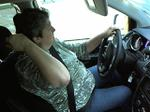
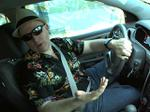
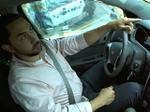
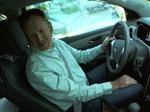
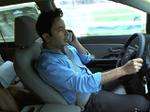
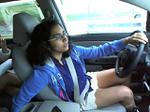
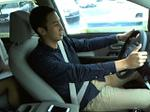
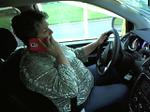
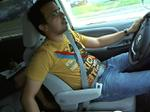
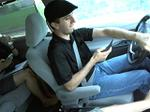
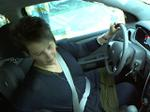
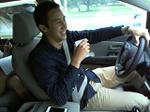
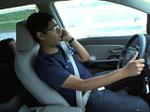
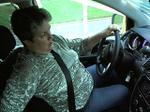
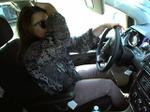
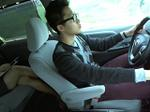
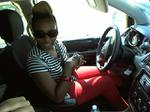
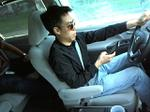
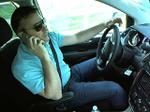
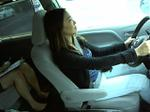
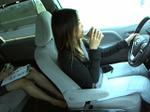
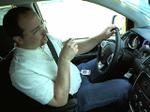
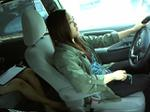
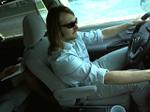
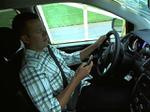
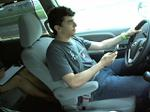
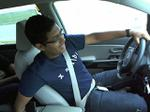
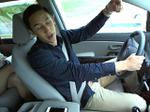
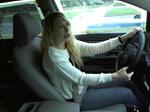
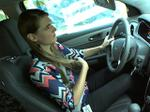
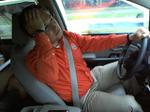
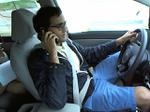
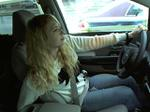
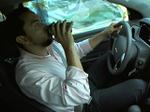
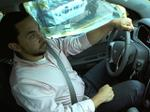
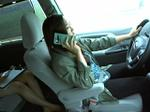
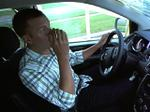
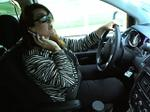
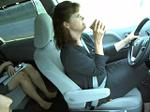
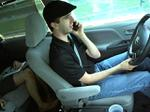
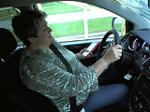
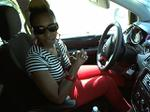
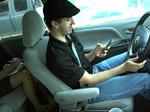
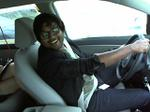
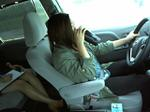
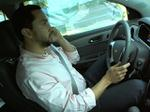
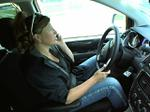
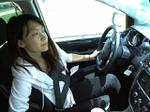
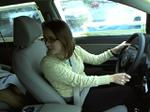
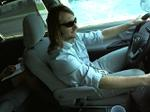
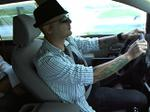
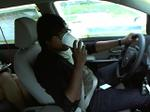
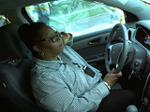
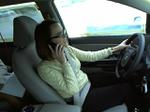
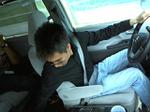
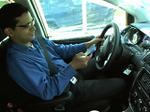
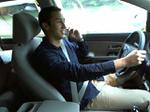
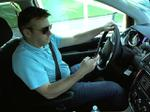
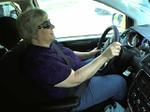
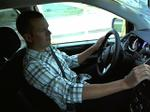
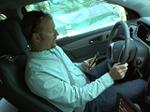
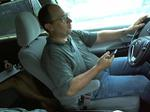
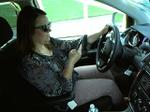
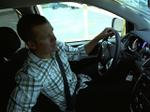
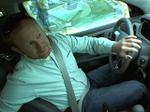
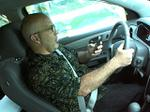
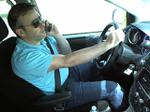
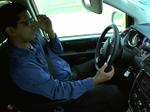
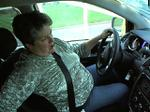
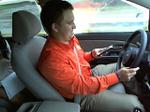
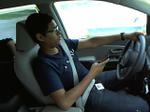
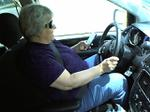
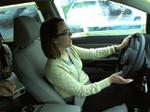
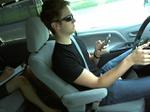
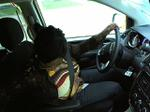
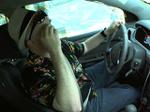
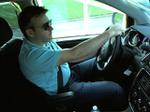
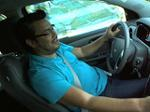
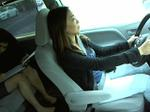
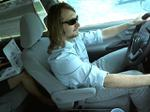
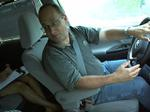
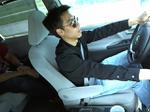
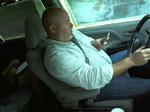
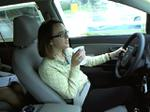
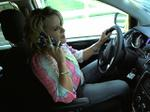
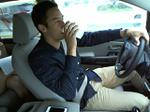
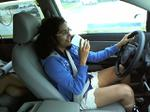
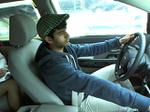
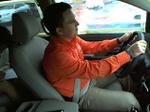
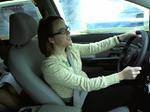
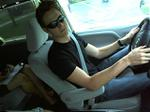
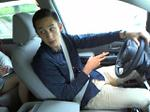
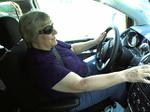
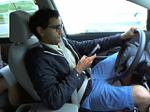
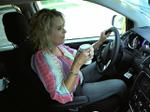
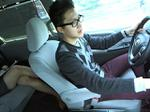
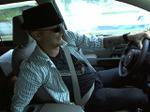
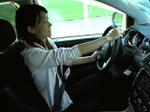
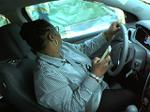
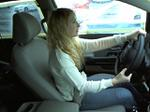
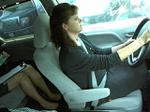
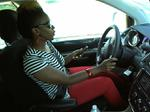
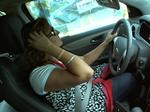
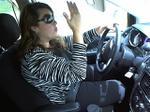
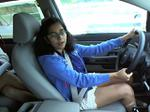
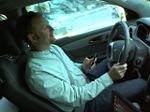
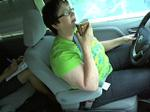
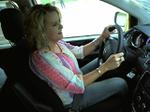
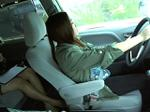
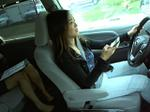
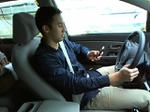
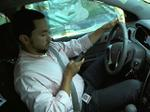
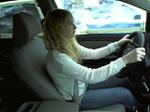
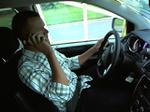
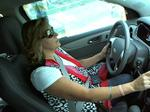
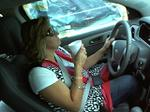
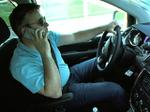
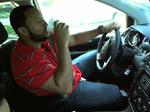
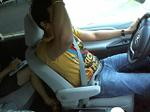
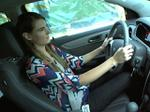
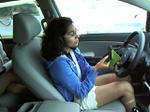
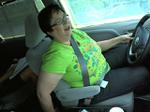
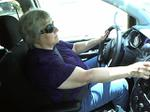
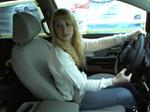
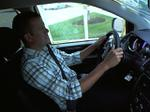
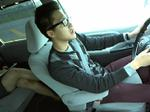
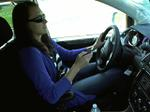
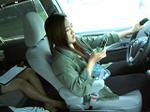
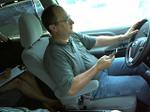
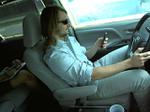
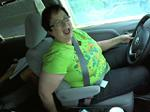
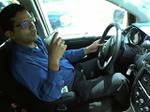
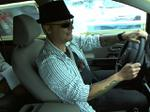
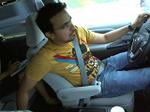
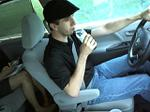
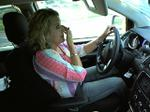
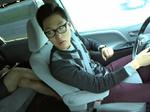
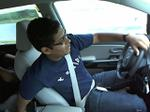
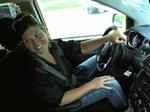
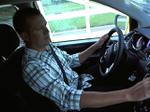
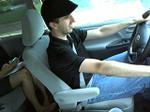
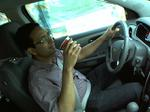
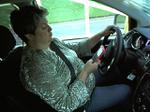
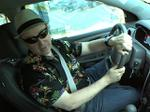
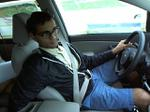
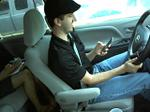
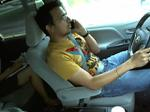
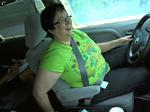
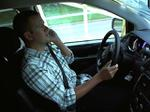
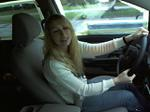
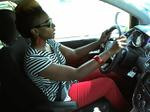
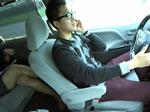
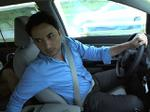
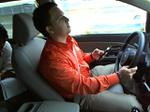
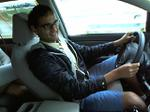
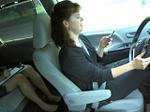
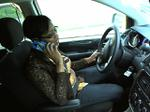
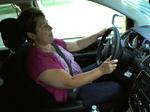
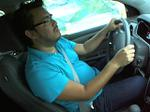
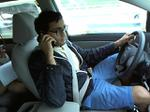
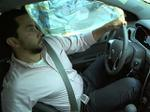
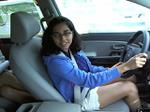
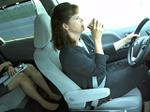
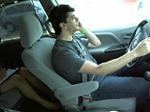
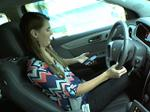
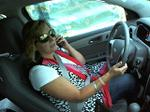
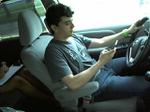
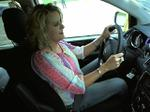
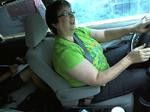
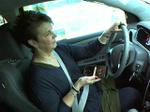
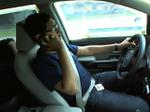
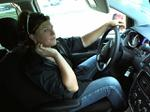
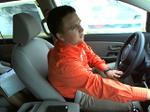
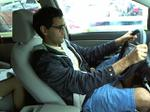
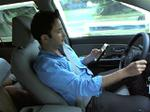
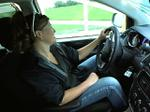
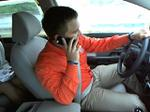
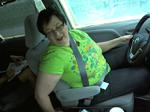
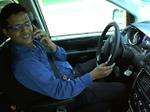
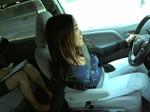
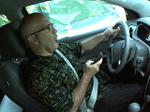
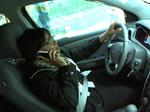
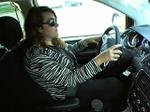
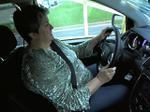
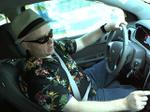
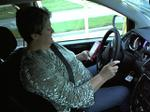
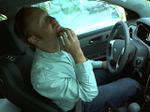
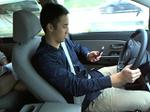
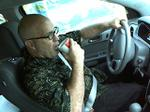
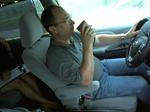
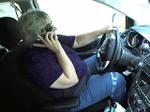
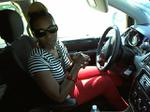
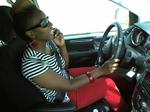
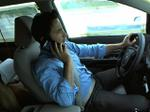
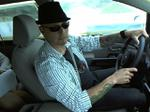
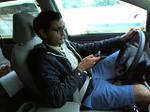
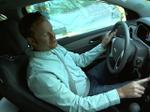
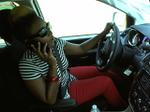
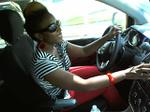
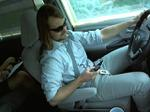
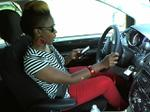
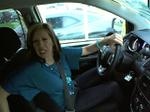
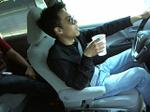
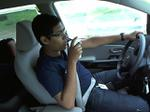
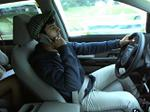
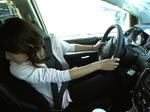
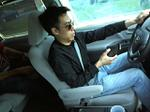
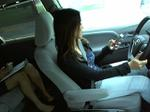
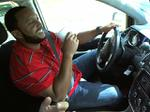
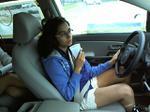
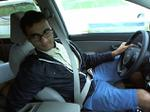
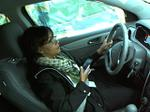
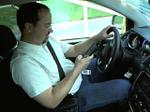
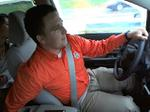
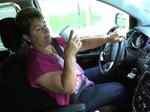
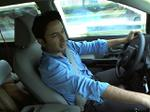
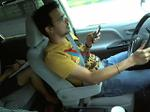
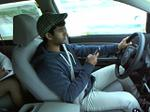
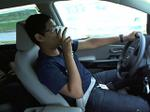
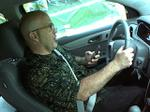
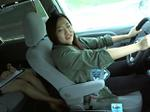
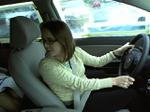
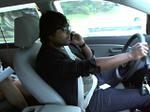
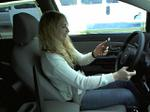
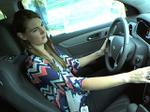
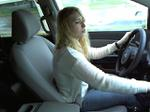
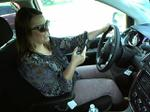
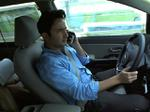
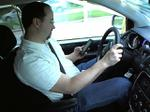
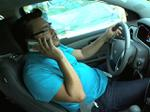
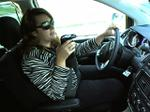
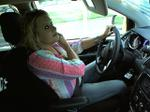
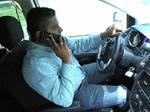
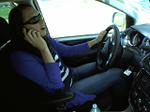
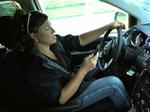
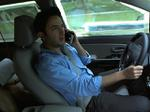
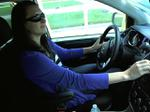
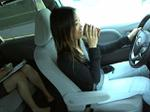
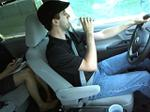
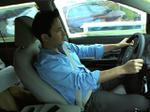
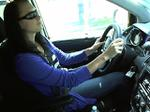
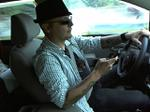
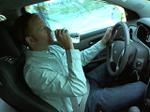
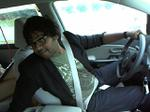
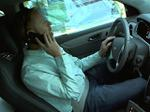
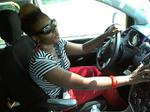
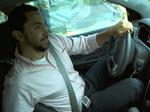
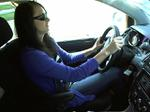
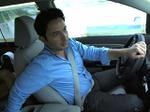
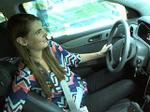
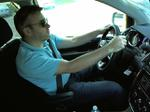
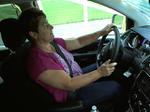
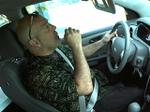
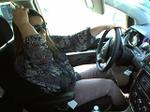
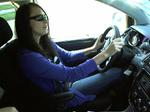
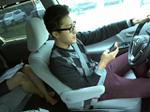
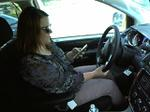
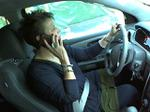
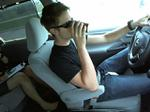
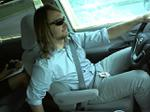
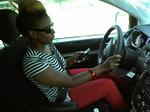
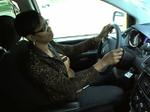
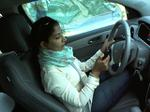
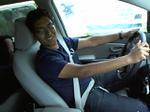
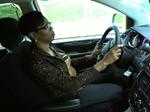
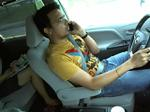
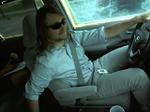
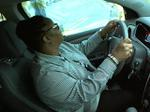
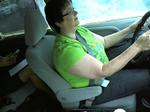
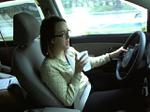
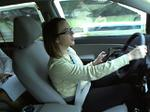
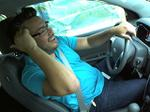
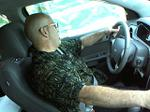
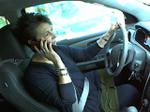
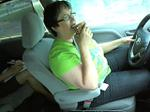
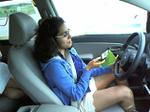
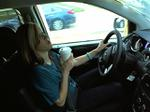
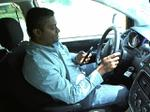
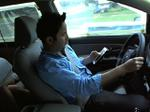
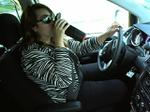
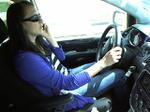
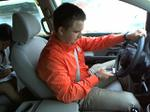
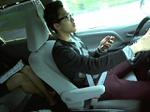
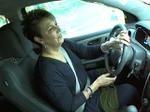
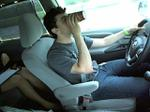
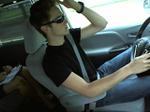
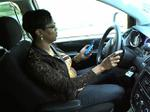
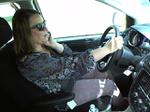
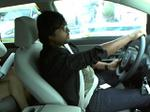
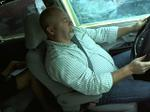
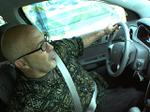
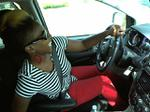
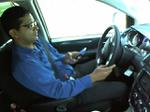
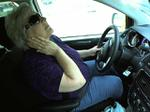
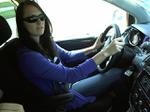
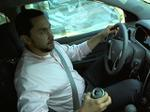
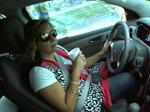
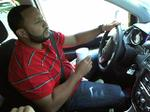
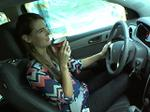
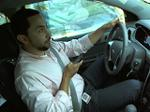
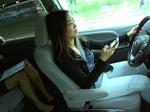
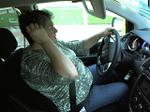
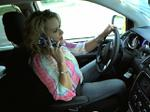
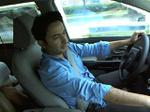
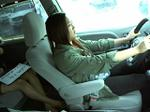
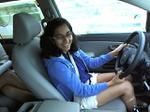
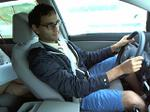
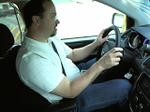
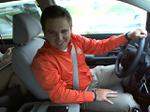
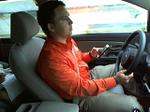
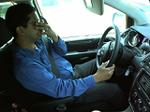
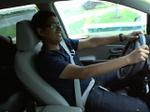
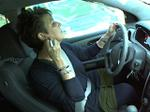
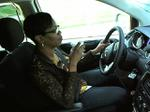
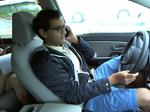
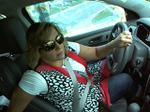
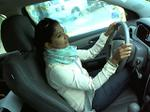
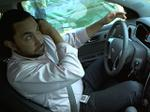
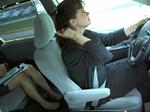
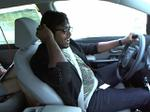
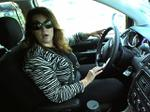
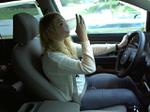
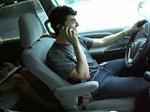
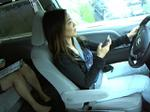
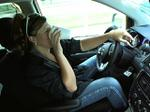
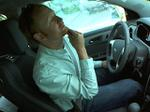
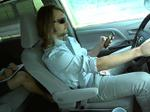
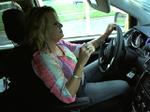
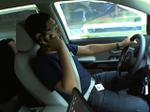
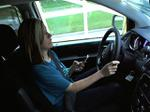
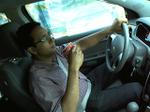
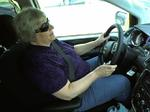
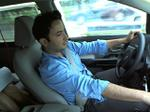
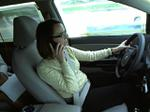
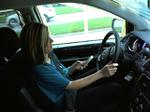
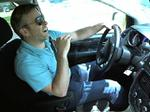
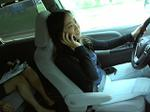
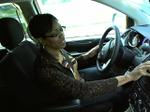
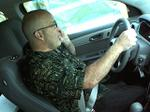
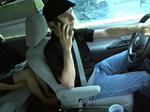
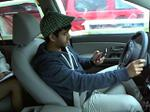
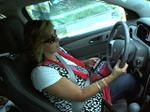
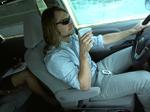
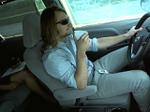
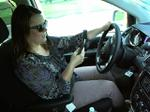
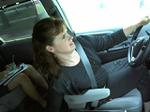
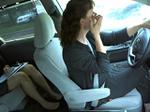
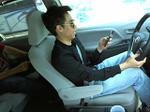
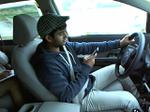
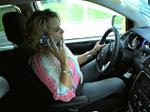
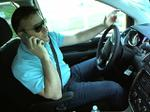
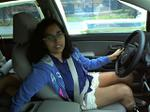
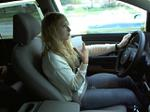
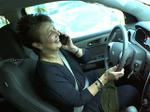
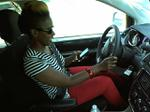
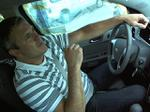
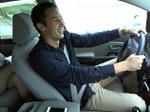
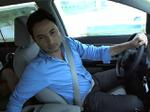
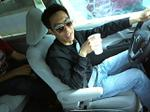
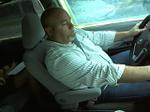
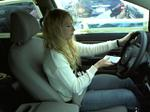
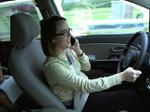
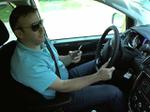
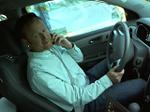
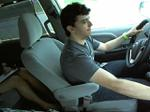
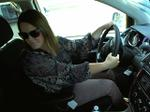
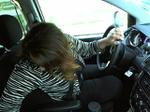
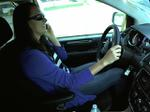
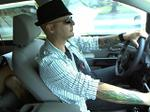
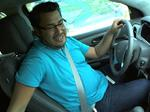
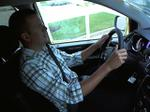
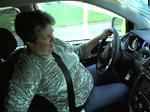
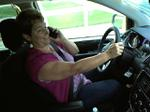
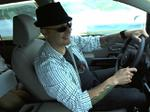
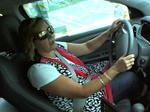
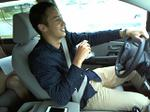
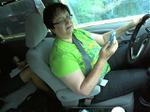
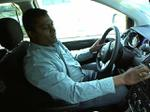
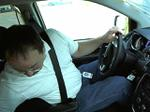
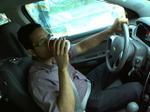
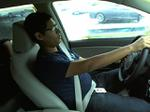
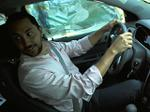
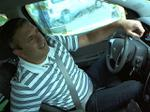
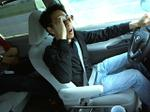
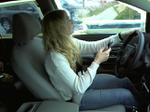
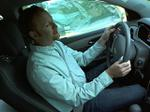
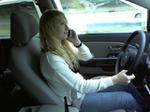
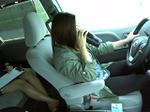
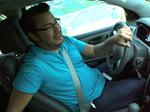
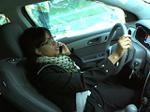
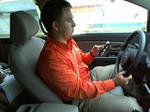
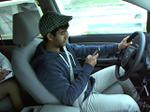
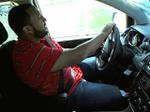
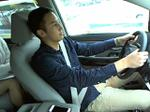
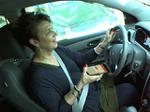
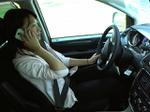
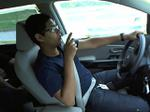
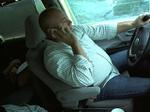
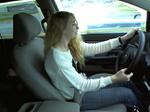
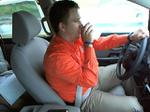
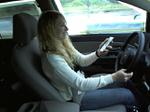
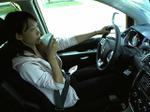
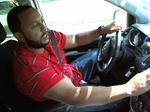
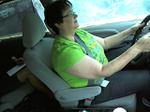
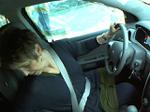
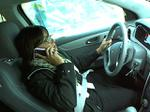
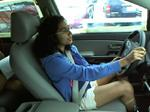
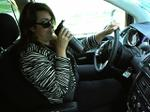
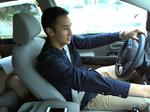
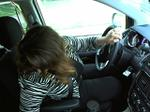
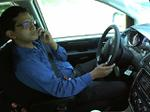
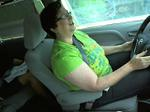
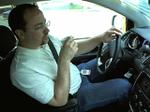
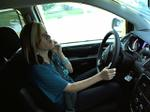
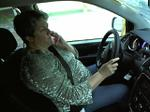
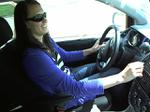
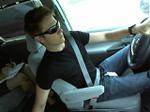
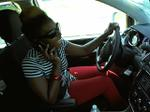
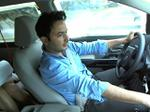
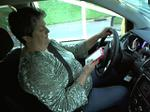
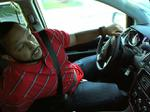
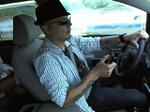
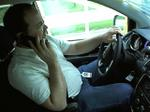
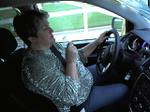
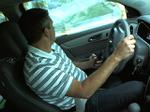
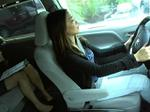
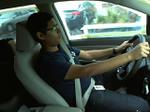
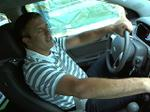
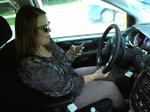
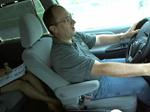
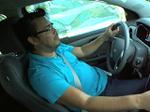
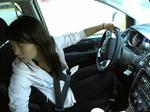
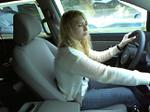
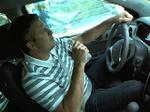
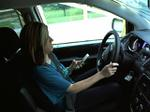
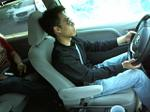
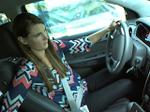
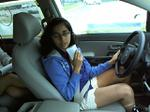
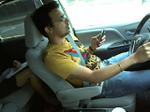
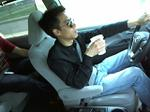
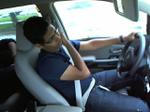
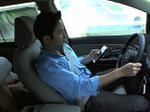
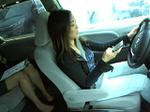
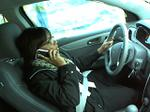
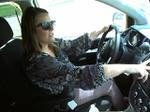
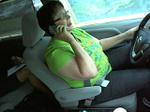
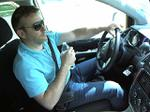
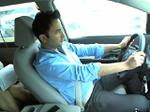
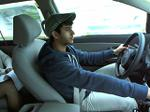
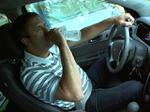
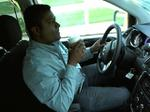
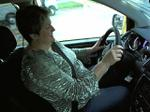
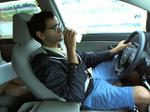
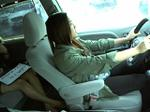
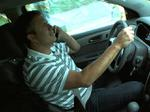
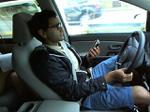
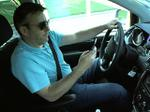
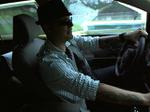
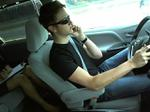
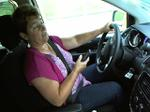
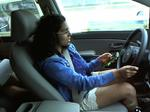
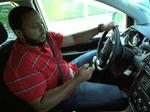
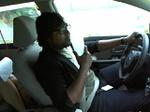
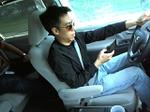
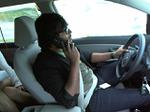
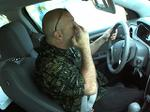
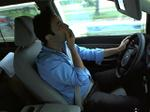
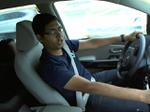
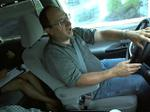
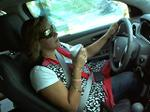
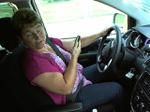
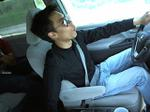
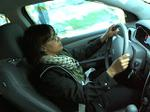
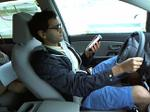
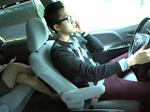
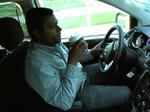
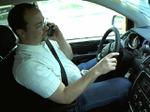
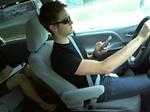
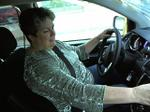
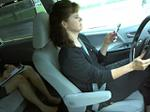
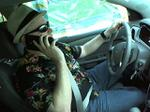
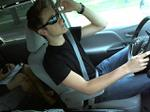
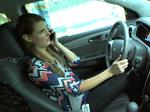
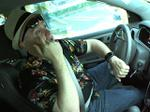
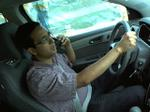
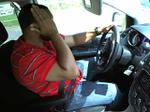
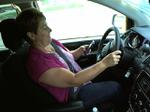
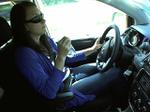
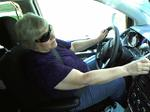
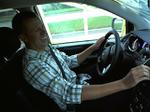
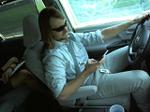
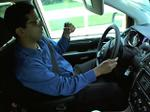
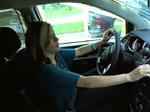
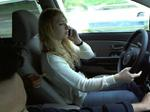
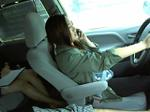
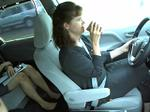
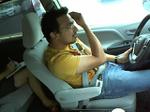
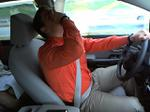
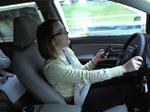
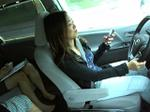
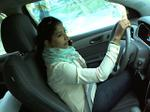
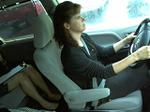
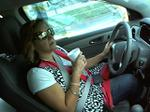
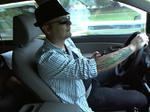
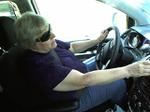
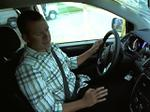
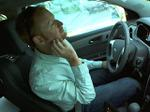
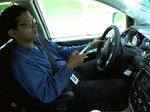
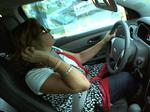
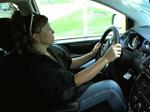
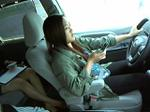
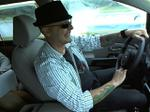
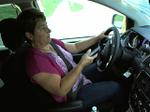
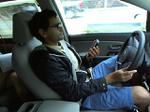
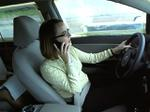
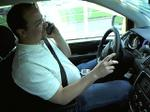
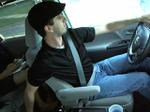
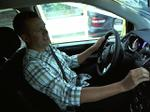
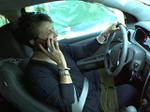
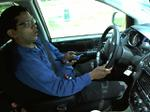
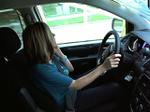
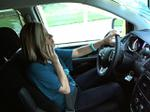
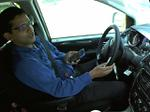
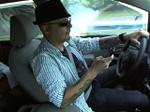
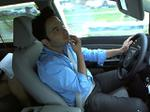
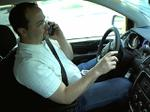
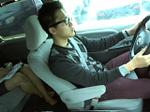
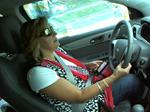
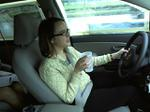
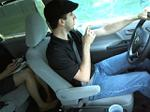
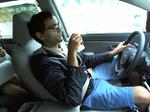
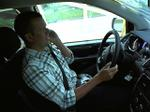
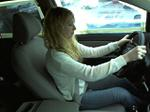
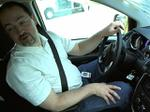
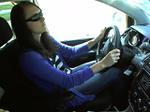
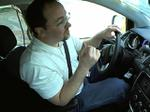
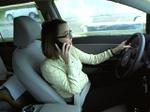
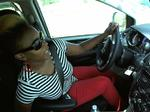
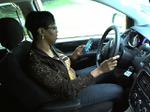
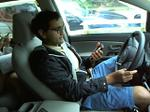
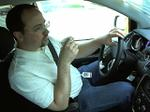
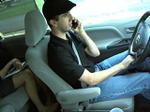
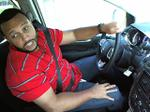
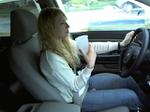
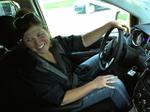
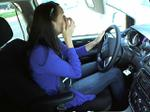
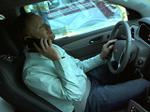
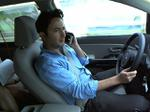
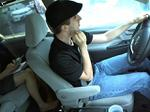
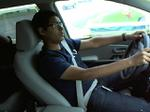
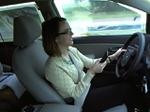
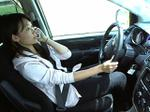
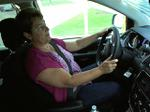
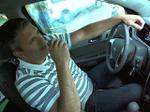
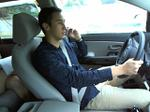
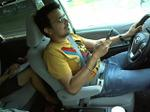
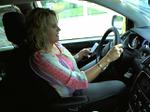
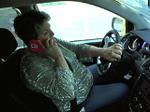
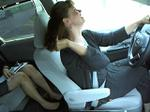
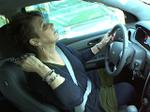
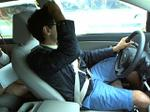
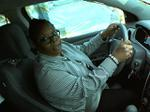
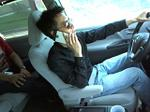
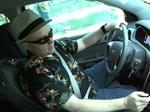
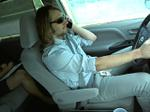
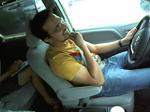
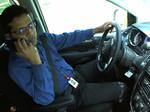
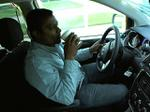

In [186]:
# displaying PIL.Image objects embedded in dataframe
HTML(predictions[['dispimage', 'Label', 'Description']].to_html(formatters={'dispimage': image_formatter}, escape=False))

In [ ]:
model.summary()

In [ ]:
np.save(working_dir_path + "/cache/X_train_conv", X_train)

In [ ]:
X_train_conv = np.load(working_dir_path + "/cache/X_train_conv.npy")

In [ ]:
top_layer = model.layers[0]
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze(), cmap='gray')

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

In [ ]:
Y_pred = model.predict_classes(X_test)

In [ ]:
Y_pred

In [ ]:
len(Y_test)

In [ ]:
Y_test.shape

In [ ]:
len(Y_pred)

In [ ]:
Y_pred.shape

In [ ]:
accuracy_score(Y_test, Y_pred)

In [ ]:
#print(y_test_without_lab)